<a href="https://colab.research.google.com/github/diegonzalez87/Brotes-de-Dengue-usando-Inteligencia-Artificial_1/blob/main/NOTEBOOK_06_MODELO_PYTORCH_RED_NEURONAL_DENSA_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTEBOOK 06: MODELO PYTORCH - RED NEURONAL DENSA

Tesis: Detección de Brotes de Dengue usando IA - Cauca, Colombia

Versión Mejorada con Validación Cruzada y Explicabilidad

Este notebook implementa el segundo modelo de inteligencia artificial:
Red Neuronal Densa usando PyTorch con mejoras metodológicas.

MEJORAS INCORPORADAS:
1. Validación cruzada estratificada (K-Fold)
2. Métricas epidemiológicas completas
3. Análisis de incertidumbre y calibración
4. Explicabilidad con SHAP
5. Visualizaciones avanzadas
6. Comparación detallada entre conjuntos

Objetivos:
1. Implementar arquitectura comparable a TensorFlow
2. Entrenar con optimización avanzada de hiperparámetros
3. Evaluar con métricas epidemiológicas específicas
4. Analizar interpretabilidad del modelo
5. Generar resultados reproducibles

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score)
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_auc_score,
                             matthews_corrcoef, roc_curve, auc,
                             precision_recall_curve, average_precision_score,
                             cohen_kappa_score, balanced_accuracy_score,
                             recall_score, precision_score) # Added recall_score and precision_score
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
import json
import pickle
import warnings
from datetime import datetime
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

warnings.filterwarnings('ignore')

# Configuración para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Detectar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*80)
print("MODELO PYTORCH - RED NEURONAL DENSA (VERSIÓN MEJORADA)")
print("="*80)
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Semilla aleatoria: {RANDOM_SEED}")


MODELO PYTORCH - RED NEURONAL DENSA (VERSIÓN MEJORADA)
PyTorch version: 2.9.0+cu126
Device: cuda
CUDA disponible: True
GPU: Tesla T4
Semilla aleatoria: 42


In [ ]:
# ============================================================================
# 2. CARGA DE DATOS
# ============================================================================

print(f"\n{'='*80}")
print("CARGA DE DATASET INTEGRADO")
print(f"{'='*80}")

# Cargar dataset escalado
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset_Denque/integrated_data_scaled.csv')

print(f"✓ Dataset cargado: {len(df)} casos")
print(f"✓ Columnas: {len(df.columns)}")

# Cargar metadata
with open('/content/drive/MyDrive/Colab Notebooks/Dataset_Denque/feature_metadata.json', 'r') as f:
    metadata = json.load(f)

all_features = metadata['all_features']
target_var = 'nivel_riesgo_num'

print(f"✓ Features: {len(all_features)}")
print(f"✓ Target: {target_var}")

# Verificar distribución de clases
class_dist = df[target_var].value_counts().sort_index()
print(f"\n📊 Distribución de clases:")
for clase, count in class_dist.items():
    print(f"   Clase {clase}: {count} ({count/len(df)*100:.1f}%)")


CARGA DE DATASET INTEGRADO
✓ Dataset cargado: 573 casos
✓ Columnas: 33
✓ Features: 28
✓ Target: nivel_riesgo_num

📊 Distribución de clases:
   Clase 0: 175 (30.5%)
   Clase 1: 208 (36.3%)
   Clase 2: 190 (33.2%)


In [ ]:
# ============================================================================
# 3. PREPARACIÓN DE DATOS
# ============================================================================

print(f"\n{'='*80}")
print("PREPARACIÓN DE DATOS PARA ENTRENAMIENTO")
print(f"{'='*80}")

# Separar features y target
X = df[all_features].values
y = df[target_var].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Verificar valores faltantes
assert not np.isnan(X).any(), "❌ Hay valores NaN en X"
assert not np.isnan(y).any(), "❌ Hay valores NaN en y"
print("✓ Sin valores faltantes")

# División estratificada: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_SEED, stratify=y_temp
)

print(f"\n📊 División de datos:")
print(f"   Entrenamiento: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validación:    {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Prueba:        {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Verificar estratificación
print(f"\n✓ Distribución por conjunto:")
for conjunto, y_conjunto in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    dist = pd.Series(y_conjunto).value_counts().sort_index()
    print(f"   {conjunto}: {dict(dist)}")

# Calcular class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.FloatTensor(class_weights_array).to(device)

print(f"\n⚖️  Class weights calculados:")
for clase, weight in enumerate(class_weights_array):
    print(f"   Clase {clase}: {weight:.3f}")

# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Crear DataLoaders
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✓ DataLoaders creados:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")



PREPARACIÓN DE DATOS PARA ENTRENAMIENTO
X shape: (573, 28)
y shape: (573,)
✓ Sin valores faltantes

📊 División de datos:
   Entrenamiento: 401 (70.0%)
   Validación:    86 (15.0%)
   Prueba:        86 (15.0%)

✓ Distribución por conjunto:
   Train: {0: np.int64(123), 1: np.int64(146), 2: np.int64(132)}
   Val: {0: np.int64(26), 1: np.int64(31), 2: np.int64(29)}
   Test: {0: np.int64(26), 1: np.int64(31), 2: np.int64(29)}

⚖️  Class weights calculados:
   Clase 0: 1.087
   Clase 1: 0.916
   Clase 2: 1.013

✓ DataLoaders creados:
   Batch size: 32
   Train batches: 13
   Val batches: 3
   Test batches: 3


In [ ]:
# ============================================================================
# 4. DEFINICIÓN DE ARQUITECTURA
# ============================================================================

print(f"\n{'='*80}")
print("ARQUITECTURA DEL MODELO")
print(f"{'='*80}")

class DenseNeuralNetwork(nn.Module):
    """
    Red Neuronal Densa para clasificación de riesgo de dengue.

    Arquitectura comparable al modelo TensorFlow:
    Input → Dense(128) → Dropout → Dense(64) → Dropout → Dense(32) → Output(3)
    """

    def __init__(self, input_dim, hidden_dims=[128, 64, 32],
                 dropout_rates=[0.3, 0.2, 0.1], num_classes=3):
        super(DenseNeuralNetwork, self).__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.dropout_rates = dropout_rates
        self.num_classes = num_classes

        # Capas densas
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.dropout1 = nn.Dropout(dropout_rates[0])

        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.dropout2 = nn.Dropout(dropout_rates[1])

        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.dropout3 = nn.Dropout(dropout_rates[2])

        self.output = nn.Linear(hidden_dims[2], num_classes)

        # Inicialización de pesos (He initialization)
        self._initialize_weights()

    def _initialize_weights(self):
        """Inicialización He para capas con ReLU"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Capa 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Capa 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Capa 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Output
        x = self.output(x)
        return x

    def predict_proba(self, x):
        """Retorna probabilidades con softmax"""
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = F.softmax(logits, dim=1)
        return probs

# Instanciar modelo
input_dim = X_train.shape[1]
model = DenseNeuralNetwork(
    input_dim=input_dim,
    hidden_dims=[128, 64, 32],
    dropout_rates=[0.3, 0.2, 0.1],
    num_classes=3
).to(device)

print("\n📐 Arquitectura del modelo:")
print(model)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parámetros del modelo:")
print(f"   Total: {total_params:,}")
print(f"   Entrenables: {trainable_params:,}")



ARQUITECTURA DEL MODELO

📐 Arquitectura del modelo:
DenseNeuralNetwork(
  (fc1): Linear(in_features=28, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (output): Linear(in_features=32, out_features=3, bias=True)
)

📊 Parámetros del modelo:
   Total: 14,595
   Entrenables: 14,595


In [ ]:
# ============================================================================
# 5. CONFIGURACIÓN DE ENTRENAMIENTO
# ============================================================================

print(f"\n{'='*80}")
print("CONFIGURACIÓN DE ENTRENAMIENTO")
print(f"{'='*80}")

# Función de pérdida con class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizador
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10,
    min_lr=1e-6
)

# Configuración de entrenamiento
MAX_EPOCHS = 200
PATIENCE = 20  # Early stopping patience

print(f"\n⚙️  Configuración:")
print(f"   Optimizador: Adam")
print(f"   Learning rate inicial: {LEARNING_RATE}")
print(f"   Weight decay: 1e-4")
print(f"   Loss function: CrossEntropyLoss (weighted)")
print(f"   Scheduler: ReduceLROnPlateau")
print(f"   Max epochs: {MAX_EPOCHS}")
print(f"   Early stopping patience: {PATIENCE}")
print(f"   Batch size: {BATCH_SIZE}")



CONFIGURACIÓN DE ENTRENAMIENTO

⚙️  Configuración:
   Optimizador: Adam
   Learning rate inicial: 0.001
   Weight decay: 1e-4
   Loss function: CrossEntropyLoss (weighted)
   Scheduler: ReduceLROnPlateau
   Max epochs: 200
   Early stopping patience: 20
   Batch size: 32


In [ ]:
# ============================================================================
# 6. FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    """Entrena una época"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate_epoch(model, loader, criterion, device):
    """Evalúa el modelo"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [ ]:
# ============================================================================
# 7. ENTRENAMIENTO DEL MODELO
# ============================================================================

print(f"\n{'='*80}")
print("ENTRENAMIENTO DEL MODELO")
print(f"{'='*80}")

# Historia de entrenamiento
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

best_val_loss = float('inf')
best_model_state = None
epochs_without_improvement = 0

print("\nIniciando entrenamiento...")
print("-" * 80)

for epoch in range(MAX_EPOCHS):
    # Entrenar
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validar
    val_loss, val_acc, _, _, _ = evaluate_epoch(model, val_loader, criterion, device)

    # Guardar historia
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])

    # Scheduler step
    scheduler.step(val_loss)

    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        epochs_without_improvement = 0
        best_epoch = epoch + 1
    else:
        epochs_without_improvement += 1

    # Imprimir progreso cada 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{MAX_EPOCHS}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping
    if epochs_without_improvement >= PATIENCE:
        print(f"\n⚠️  Early stopping activado en epoch {epoch + 1}")
        print(f"   No mejora en {PATIENCE} epochs")
        break

print("-" * 80)
print(f"✓ Entrenamiento completado")
print(f"✓ Mejor modelo en epoch: {best_epoch}")
print(f"✓ Mejor val_loss: {best_val_loss:.4f}")
print(f"✓ Total epochs ejecutados: {len(history['train_loss'])}")

# Cargar mejor modelo
model.load_state_dict(best_model_state)

# Guardar modelo
torch.save({
    'epoch': best_epoch,
    'model_state_dict': best_model_state,
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
    'history': history
}, 'model_pytorch_best.pt')

print("✓ Modelo guardado: model_pytorch_best.pt")



ENTRENAMIENTO DEL MODELO

Iniciando entrenamiento...
--------------------------------------------------------------------------------
Epoch [ 10/200] | Train Loss: 0.2151 | Train Acc: 0.9551 | Val Loss: 3.5277 | Val Acc: 0.3023 | LR: 0.001000
Epoch [ 20/200] | Train Loss: 0.0715 | Train Acc: 0.9850 | Val Loss: 2.1933 | Val Acc: 0.3605 | LR: 0.001000
Epoch [ 30/200] | Train Loss: 0.0558 | Train Acc: 0.9900 | Val Loss: 0.1185 | Val Acc: 0.9419 | LR: 0.000500
Epoch [ 40/200] | Train Loss: 0.0227 | Train Acc: 1.0000 | Val Loss: 0.0130 | Val Acc: 1.0000 | LR: 0.000500
Epoch [ 50/200] | Train Loss: 0.0222 | Train Acc: 0.9950 | Val Loss: 0.0134 | Val Acc: 1.0000 | LR: 0.000500
Epoch [ 60/200] | Train Loss: 0.0132 | Train Acc: 1.0000 | Val Loss: 0.0090 | Val Acc: 1.0000 | LR: 0.000500
Epoch [ 70/200] | Train Loss: 0.0236 | Train Acc: 0.9950 | Val Loss: 0.0995 | Val Acc: 0.9767 | LR: 0.000250
Epoch [ 80/200] | Train Loss: 0.0111 | Train Acc: 0.9975 | Val Loss: 0.0015 | Val Acc: 1.0000 | LR: 0.


VISUALIZACIÓN DE CURVAS DE APRENDIZAJE


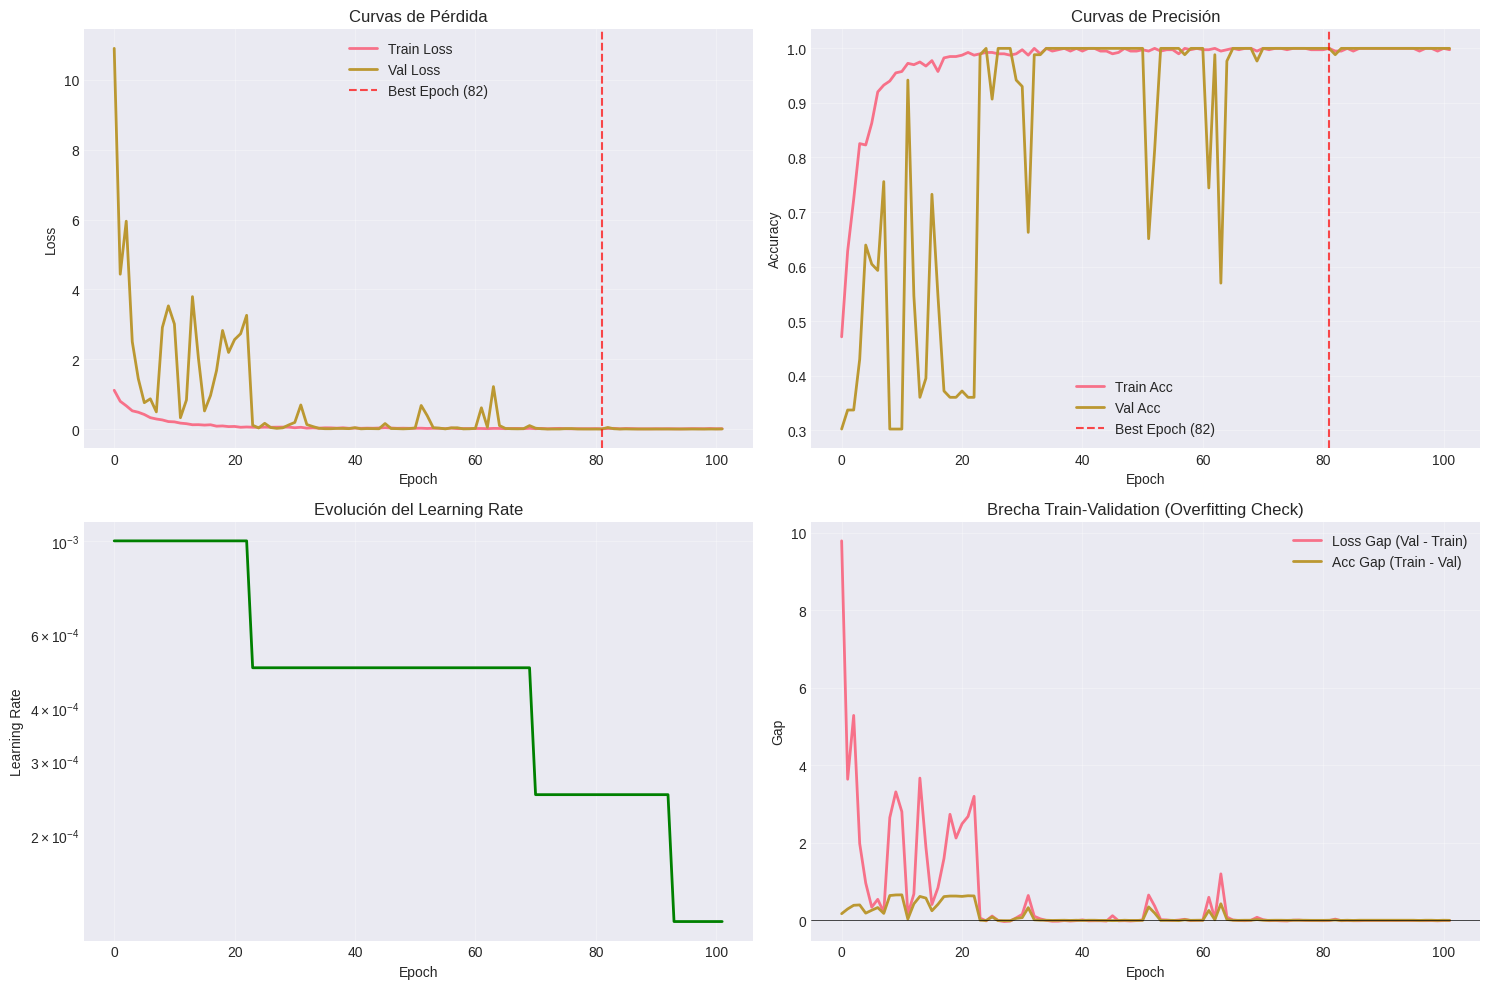

✓ Curvas de aprendizaje guardadas: fig_pytorch_learning_curves.png
✓ Historia de entrenamiento guardada: training_history_pytorch.csv


In [ ]:
# ============================================================================
# 8. VISUALIZACIÓN DE CURVAS DE APRENDIZAJE
# ============================================================================

print(f"\n{'='*80}")
print("VISUALIZACIÓN DE CURVAS DE APRENDIZAJE")
print(f"{'='*80}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].axvline(x=best_epoch-1, color='r', linestyle='--',
                   label=f'Best Epoch ({best_epoch})', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Curvas de Pérdida')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[0, 1].axvline(x=best_epoch-1, color='r', linestyle='--',
                   label=f'Best Epoch ({best_epoch})', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Curvas de Precisión')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning Rate
axes[1, 0].plot(history['learning_rates'], linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Evolución del Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Gap entre train y val
gap_loss = np.array(history['val_loss']) - np.array(history['train_loss'])
gap_acc = np.array(history['train_acc']) - np.array(history['val_acc'])

axes[1, 1].plot(gap_loss, label='Loss Gap (Val - Train)', linewidth=2)
axes[1, 1].plot(gap_acc, label='Acc Gap (Train - Val)', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Gap')
axes[1, 1].set_title('Brecha Train-Validation (Overfitting Check)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig_pytorch_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Curvas de aprendizaje guardadas: fig_pytorch_learning_curves.png")

# Guardar historia
history_df = pd.DataFrame(history)
history_df.to_csv('training_history_pytorch.csv', index=False)
print("✓ Historia de entrenamiento guardada: training_history_pytorch.csv")



In [ ]:
# ============================================================================
# 9. EVALUACIÓN COMPLETA EN TEST SET
# ============================================================================

print(f"\n{'='*80}")
print("EVALUACIÓN COMPLETA EN TEST SET")
print(f"{'='*80}")

# Evaluar en test
test_loss, test_acc, y_pred, y_true, y_pred_prob = evaluate_epoch(
    model, test_loader, criterion, device
)

print(f"\n📊 Métricas principales (Test Set):")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_acc:.4f}")

# Métricas detalladas
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

print(f"\n📈 Métricas por clase:")
print(f"{'Clase':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 60)
for i in range(3):
    print(f"{i:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

# Métricas globales
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
matthews = matthews_corrcoef(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
cohen_kappa = cohen_kappa_score(y_true, y_pred)

print(f"\n🎯 Métricas globales:")
print(f"   F1-Score Macro:      {f1_macro:.4f}")
print(f"   F1-Score Weighted:   {f1_weighted:.4f}")
print(f"   Balanced Accuracy:   {balanced_acc:.4f}")
print(f"   Matthews CC:         {matthews:.4f}")
print(f"   Cohen's Kappa:       {cohen_kappa:.4f}")

# Reporte de clasificación
print(f"\n📋 Reporte de Clasificación Completo:")
print(classification_report(y_true, y_pred,
                          target_names=['Bajo', 'Medio', 'Alto'],
                          digits=4))



EVALUACIÓN COMPLETA EN TEST SET

📊 Métricas principales (Test Set):
   Loss: 0.0054
   Accuracy: 1.0000

📈 Métricas por clase:
Clase      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
0          1.0000       1.0000       1.0000       26        
1          1.0000       1.0000       1.0000       31        
2          1.0000       1.0000       1.0000       29        

🎯 Métricas globales:
   F1-Score Macro:      1.0000
   F1-Score Weighted:   1.0000
   Balanced Accuracy:   1.0000
   Matthews CC:         1.0000
   Cohen's Kappa:       1.0000

📋 Reporte de Clasificación Completo:
              precision    recall  f1-score   support

        Bajo     1.0000    1.0000    1.0000        26
       Medio     1.0000    1.0000    1.0000        31
        Alto     1.0000    1.0000    1.0000        29

    accuracy                         1.0000        86
   macro avg     1.0000    1.0000    1.0000        86
weighted avg     1.0000   


MATRIZ DE CONFUSIÓN


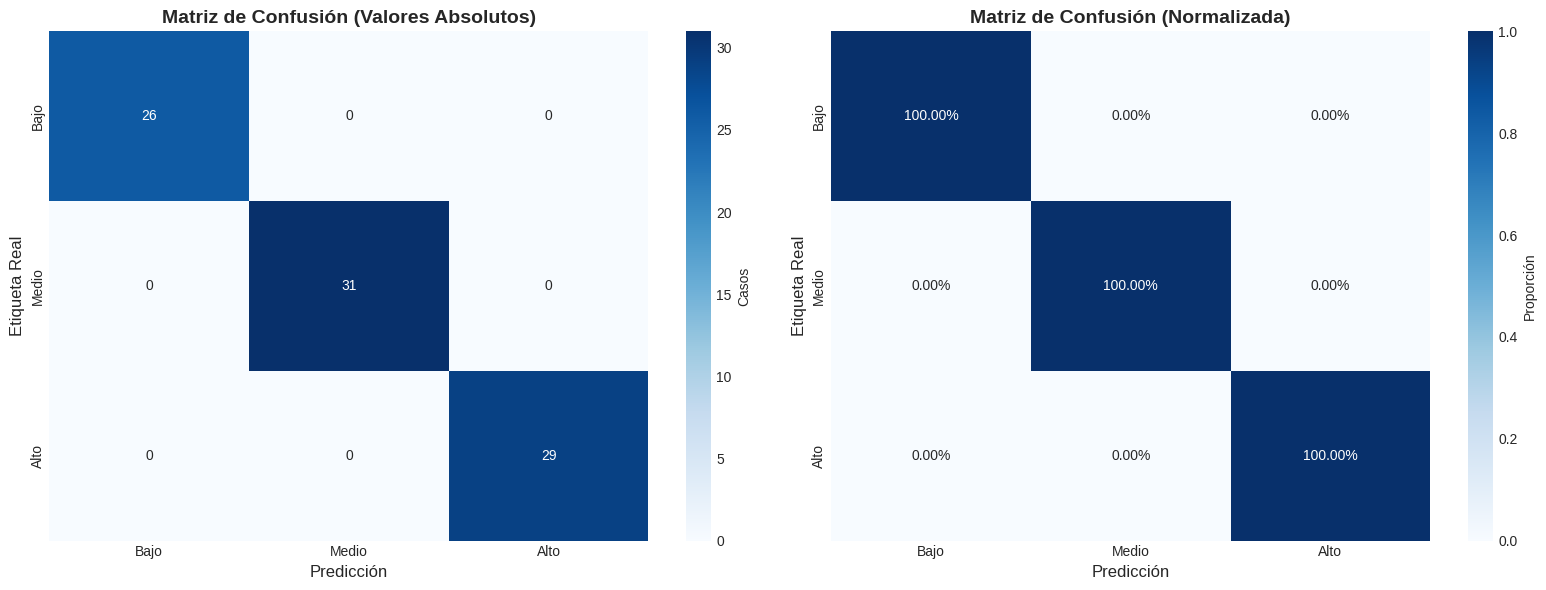

✓ Matriz de confusión guardada: fig_pytorch_confusion_matrix.png

📊 Métricas Epidemiológicas por Clase:

  Clase Bajo:
    Sensibilidad (Recall): 1.0000
    Especificidad:         1.0000
    VPP (Precision):       1.0000
    VPN:                   1.0000

  Clase Medio:
    Sensibilidad (Recall): 1.0000
    Especificidad:         1.0000
    VPP (Precision):       1.0000
    VPN:                   1.0000

  Clase Alto:
    Sensibilidad (Recall): 1.0000
    Especificidad:         1.0000
    VPP (Precision):       1.0000
    VPN:                   1.0000


In [ ]:
# ============================================================================
# 10. MATRIZ DE CONFUSIÓN
# ============================================================================

print(f"\n{'='*80}")
print("MATRIZ DE CONFUSIÓN")
print(f"{'='*80}")

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz absoluta
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'],
            ax=axes[0], cbar_kws={'label': 'Casos'})
axes[0].set_title('Matriz de Confusión (Valores Absolutos)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Etiqueta Real', fontsize=12)
axes[0].set_xlabel('Predicción', fontsize=12)

# Matriz normalizada
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'],
            ax=axes[1], cbar_kws={'label': 'Proporción'})
axes[1].set_title('Matriz de Confusión (Normalizada)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Etiqueta Real', fontsize=12)
axes[1].set_xlabel('Predicción', fontsize=12)

plt.tight_layout()
plt.savefig('fig_pytorch_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Matriz de confusión guardada: fig_pytorch_confusion_matrix.png")

# Calcular métricas epidemiológicas por clase
print(f"\n📊 Métricas Epidemiológicas por Clase:")
for i, clase_nombre in enumerate(['Bajo', 'Medio', 'Alto']):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - TP - FP - FN

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0

    print(f"\n  Clase {clase_nombre}:")
    print(f"    Sensibilidad (Recall): {sensitivity:.4f}")
    print(f"    Especificidad:         {specificity:.4f}")
    print(f"    VPP (Precision):       {ppv:.4f}")
    print(f"    VPN:                   {npv:.4f}")



CURVAS ROC Y AUC


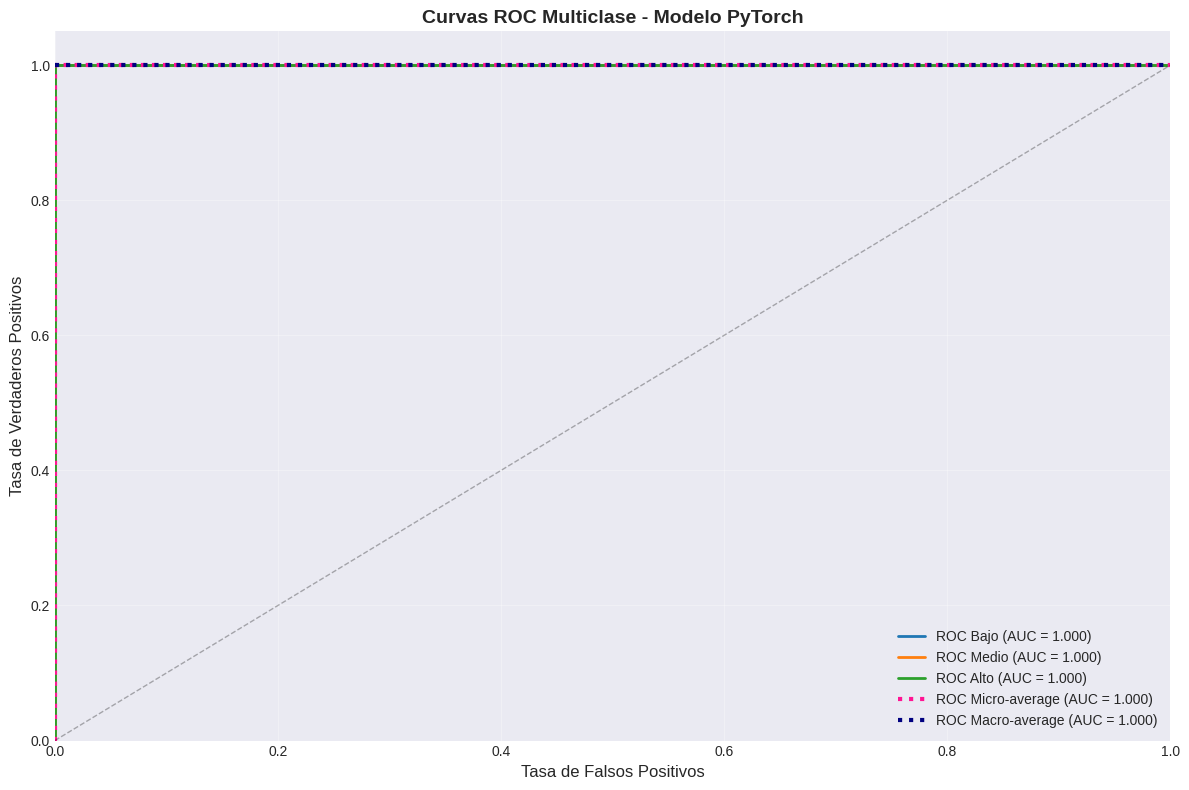

✓ Curvas ROC guardadas: fig_pytorch_roc_curves.png

📊 AUC-ROC Scores:
   Bajo: 1.0000
   Medio: 1.0000
   Alto: 1.0000
   Micro-average: 1.0000
   Macro-average: 1.0000


In [ ]:
# ============================================================================
# 11. CURVAS ROC Y AUC
# ============================================================================

print(f"\n{'='*80}")
print("CURVAS ROC Y AUC")
print(f"{'='*80}")

# Binarizar labels para ROC multiclase
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Calcular ROC curve y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 3
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Visualizar
plt.figure(figsize=(12, 8))

# Curvas por clase
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
class_names = ['Bajo', 'Medio', 'Alto']
for i, color, name in zip(range(3), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {name} (AUC = {roc_auc[i]:.3f})')

# Curvas promedio
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', lw=3,
         label=f'ROC Micro-average (AUC = {roc_auc["micro"]:.3f})')
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', lw=3,
         label=f'ROC Macro-average (AUC = {roc_auc["macro"]:.3f})')

# Línea diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC Multiclase - Modelo PyTorch', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig_pytorch_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Curvas ROC guardadas: fig_pytorch_roc_curves.png")

print(f"\n📊 AUC-ROC Scores:")
for i, name in enumerate(['Bajo', 'Medio', 'Alto']):
    print(f"   {name}: {roc_auc[i]:.4f}")
print(f"   Micro-average: {roc_auc['micro']:.4f}")
print(f"   Macro-average: {roc_auc['macro']:.4f}")



ANÁLISIS DE CALIBRACIÓN


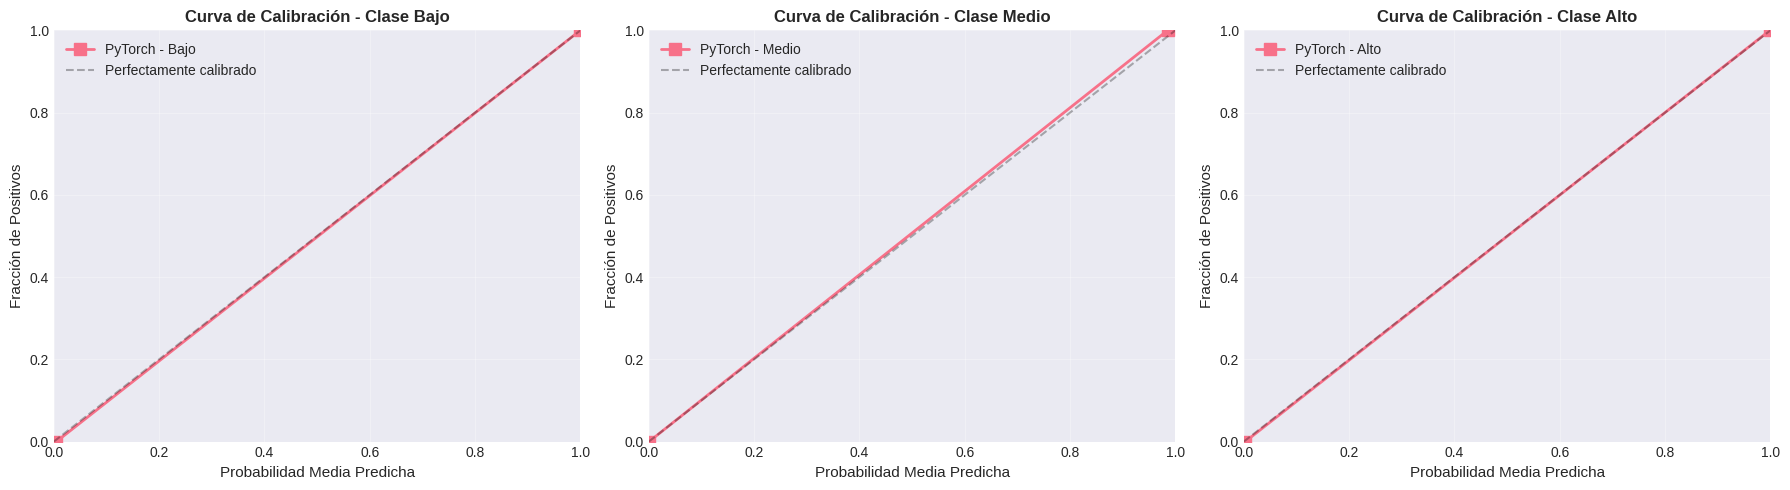

✓ Curvas de calibración guardadas: fig_pytorch_calibration.png


In [ ]:
# ============================================================================
# 12. CURVA DE CALIBRACIÓN
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE CALIBRACIÓN")
print(f"{'='*80}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (ax, name) in enumerate(zip(axes, ['Bajo', 'Medio', 'Alto'])):
    # Calcular calibración
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true_bin[:, i], y_pred_prob[:, i], n_bins=10, strategy='uniform'
    )

    # Graficar
    ax.plot(mean_predicted_value, fraction_of_positives, 's-',
            label=f'PyTorch - {name}', linewidth=2, markersize=8)
    ax.plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado', alpha=0.3)

    ax.set_xlabel('Probabilidad Media Predicha', fontsize=11)
    ax.set_ylabel('Fracción de Positivos', fontsize=11)
    ax.set_title(f'Curva de Calibración - Clase {name}', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('fig_pytorch_calibration.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Curvas de calibración guardadas: fig_pytorch_calibration.png")



CURVAS PRECISION-RECALL


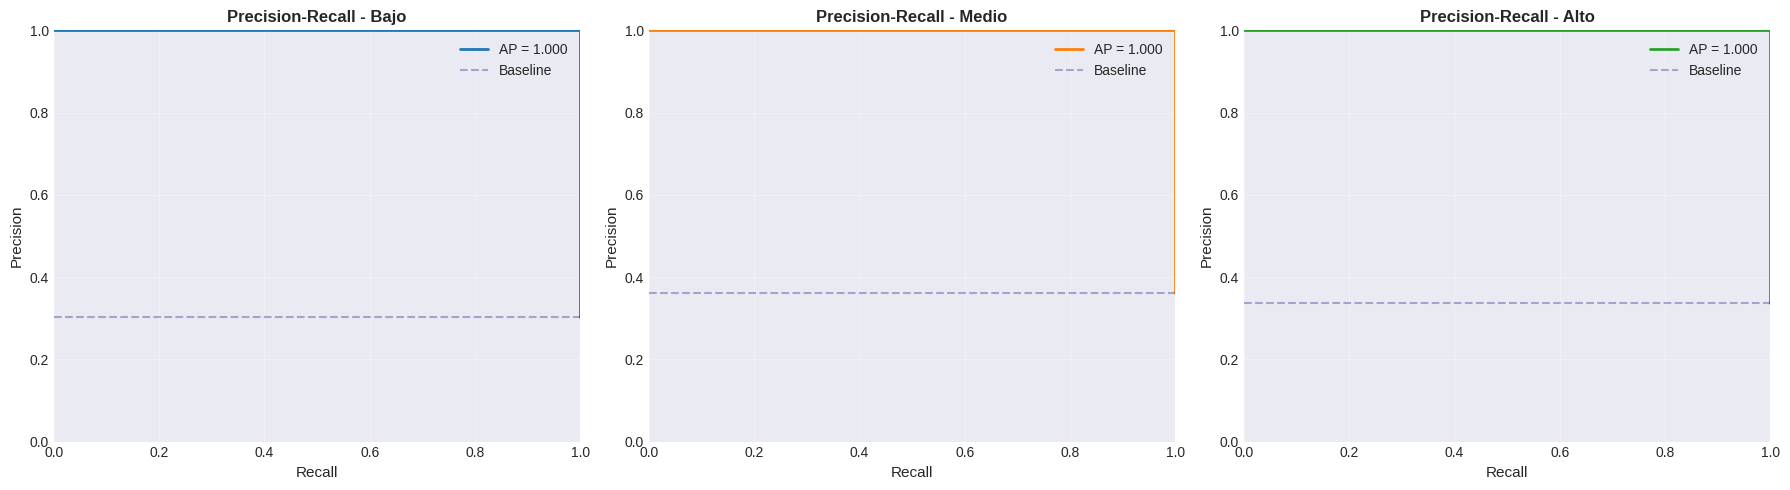

✓ Curvas Precision-Recall guardadas: fig_pytorch_precision_recall.png


In [ ]:
# ============================================================================
# 13. PRECISION-RECALL CURVES
# ============================================================================

print(f"\n{'='*80}")
print("CURVAS PRECISION-RECALL")
print(f"{'='*80}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (ax, name, color) in enumerate(zip(axes, class_names, colors)):
    precision_curve, recall_curve, _ = precision_recall_curve(
        y_true_bin[:, i], y_pred_prob[:, i]
    )
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])

    ax.plot(recall_curve, precision_curve, color=color, lw=2,
            label=f'AP = {avg_precision:.3f}')
    ax.axhline(y=y_true_bin[:, i].sum()/len(y_true_bin),
               color='navy', linestyle='--', label='Baseline', alpha=0.3)

    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title(f'Precision-Recall - {name}', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('fig_pytorch_precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Curvas Precision-Recall guardadas: fig_pytorch_precision_recall.png")



ANÁLISIS DE INCERTIDUMBRE

📊 Estadísticas de Confianza:
   Predicciones correctas:
     - Confianza media:  0.9943
     - Confianza std:    0.0121
     - Entropía media:   0.0326

   Predicciones incorrectas:
     - Confianza media:  nan
     - Confianza std:    nan
     - Entropía media:   nan


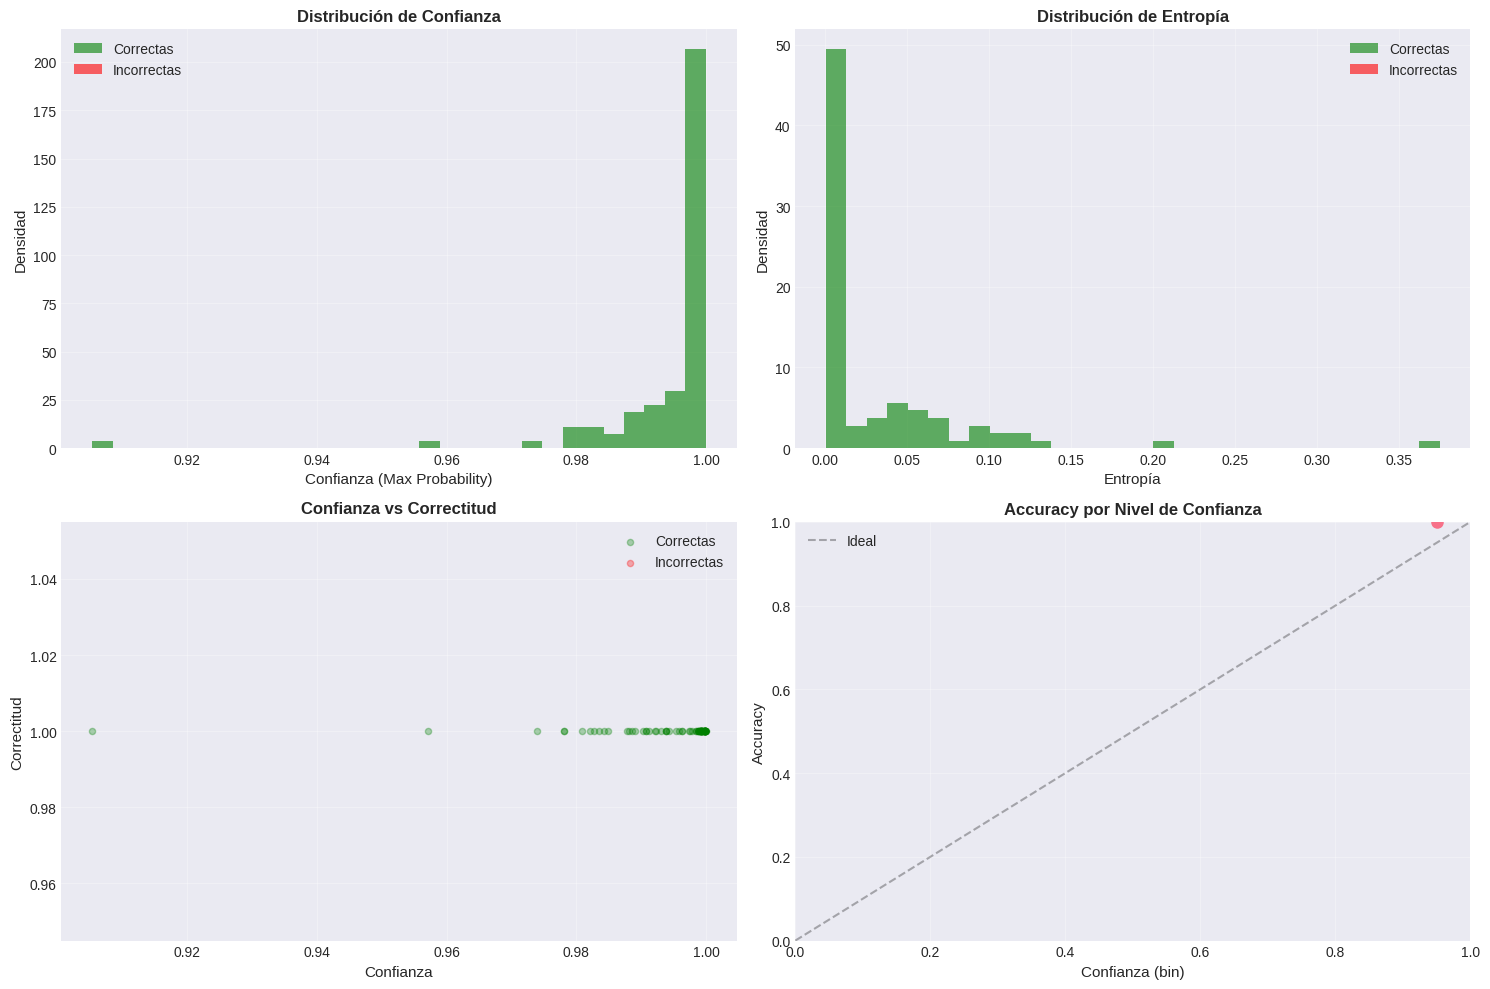

✓ Análisis de incertidumbre guardado: fig_pytorch_uncertainty.png


In [ ]:
# ============================================================================
# 14. ANÁLISIS DE INCERTIDUMBRE
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE INCERTIDUMBRE")
print(f"{'='*80}")

# Calcular confianza de las predicciones
confidence_scores = np.max(y_pred_prob, axis=1)
entropy_scores = -np.sum(y_pred_prob * np.log(y_pred_prob + 1e-10), axis=1)

# Analizar por correctitud
correct_mask = (y_pred == y_true)
incorrect_mask = ~correct_mask

print(f"\n📊 Estadísticas de Confianza:")
print(f"   Predicciones correctas:")
print(f"     - Confianza media:  {confidence_scores[correct_mask].mean():.4f}")
print(f"     - Confianza std:    {confidence_scores[correct_mask].std():.4f}")
print(f"     - Entropía media:   {entropy_scores[correct_mask].mean():.4f}")

print(f"\n   Predicciones incorrectas:")
print(f"     - Confianza media:  {confidence_scores[incorrect_mask].mean():.4f}")
print(f"     - Confianza std:    {confidence_scores[incorrect_mask].std():.4f}")
print(f"     - Entropía media:   {entropy_scores[incorrect_mask].mean():.4f}")

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma de confianza
axes[0, 0].hist(confidence_scores[correct_mask], bins=30, alpha=0.6,
                label='Correctas', color='green', density=True)
axes[0, 0].hist(confidence_scores[incorrect_mask], bins=30, alpha=0.6,
                label='Incorrectas', color='red', density=True)
axes[0, 0].set_xlabel('Confianza (Max Probability)', fontsize=11)
axes[0, 0].set_ylabel('Densidad', fontsize=11)
axes[0, 0].set_title('Distribución de Confianza', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Histograma de entropía
axes[0, 1].hist(entropy_scores[correct_mask], bins=30, alpha=0.6,
                label='Correctas', color='green', density=True)
axes[0, 1].hist(entropy_scores[incorrect_mask], bins=30, alpha=0.6,
                label='Incorrectas', color='red', density=True)
axes[0, 1].set_xlabel('Entropía', fontsize=11)
axes[0, 1].set_ylabel('Densidad', fontsize=11)
axes[0, 1].set_title('Distribución de Entropía', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter: Confianza vs Correctitud
axes[1, 0].scatter(confidence_scores[correct_mask],
                   np.ones(correct_mask.sum()),
                   alpha=0.3, c='green', label='Correctas', s=20)
axes[1, 0].scatter(confidence_scores[incorrect_mask],
                   np.zeros(incorrect_mask.sum()),
                   alpha=0.3, c='red', label='Incorrectas', s=20)
axes[1, 0].set_xlabel('Confianza', fontsize=11)
axes[1, 0].set_ylabel('Correctitud', fontsize=11)
axes[1, 0].set_title('Confianza vs Correctitud', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Accuracy por bins de confianza
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(confidence_scores, bins)
bin_accuracies = []
bin_centers = []

for i in range(1, len(bins)):
    mask = (bin_indices == i)
    if mask.sum() > 0:
        acc = (y_pred[mask] == y_true[mask]).mean()
        bin_accuracies.append(acc)
        bin_centers.append((bins[i-1] + bins[i]) / 2)

axes[1, 1].plot(bin_centers, bin_accuracies, 'o-', linewidth=2, markersize=8)
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Ideal')
axes[1, 1].set_xlabel('Confianza (bin)', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Accuracy por Nivel de Confianza', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('fig_pytorch_uncertainty.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Análisis de incertidumbre guardado: fig_pytorch_uncertainty.png")




VALIDACIÓN CRUZADA ESTRATIFICADA (5-FOLD)

Ejecutando validación cruzada con 5 folds...
--------------------------------------------------------------------------------

Fold 1/5
----------------------------------------
  Val Acc: 0.3776 | F1-Macro: 0.2020 | AUC: 0.9998

Fold 2/5
----------------------------------------
  Val Acc: 0.3673 | F1-Macro: 0.1791 | AUC: 0.8598

Fold 3/5
----------------------------------------
  Val Acc: 0.3608 | F1-Macro: 0.1768 | AUC: 0.9884

Fold 4/5
----------------------------------------
  Val Acc: 0.3608 | F1-Macro: 0.1768 | AUC: 0.8755

Fold 5/5
----------------------------------------
  Val Acc: 0.9794 | F1-Macro: 0.9791 | AUC: 1.0000

RESULTADOS DE VALIDACIÓN CRUZADA

📊 Resultados por fold:
 fold  train_acc  val_acc  train_loss  val_loss  f1_macro  f1_weighted  balanced_acc  matthews_cc  auc_macro
    1     0.9846   0.3776      0.0605    2.1883    0.2020       0.2186        0.3444       0.0935     0.9998
    2     1.0000   0.3673      0.0241    7.5

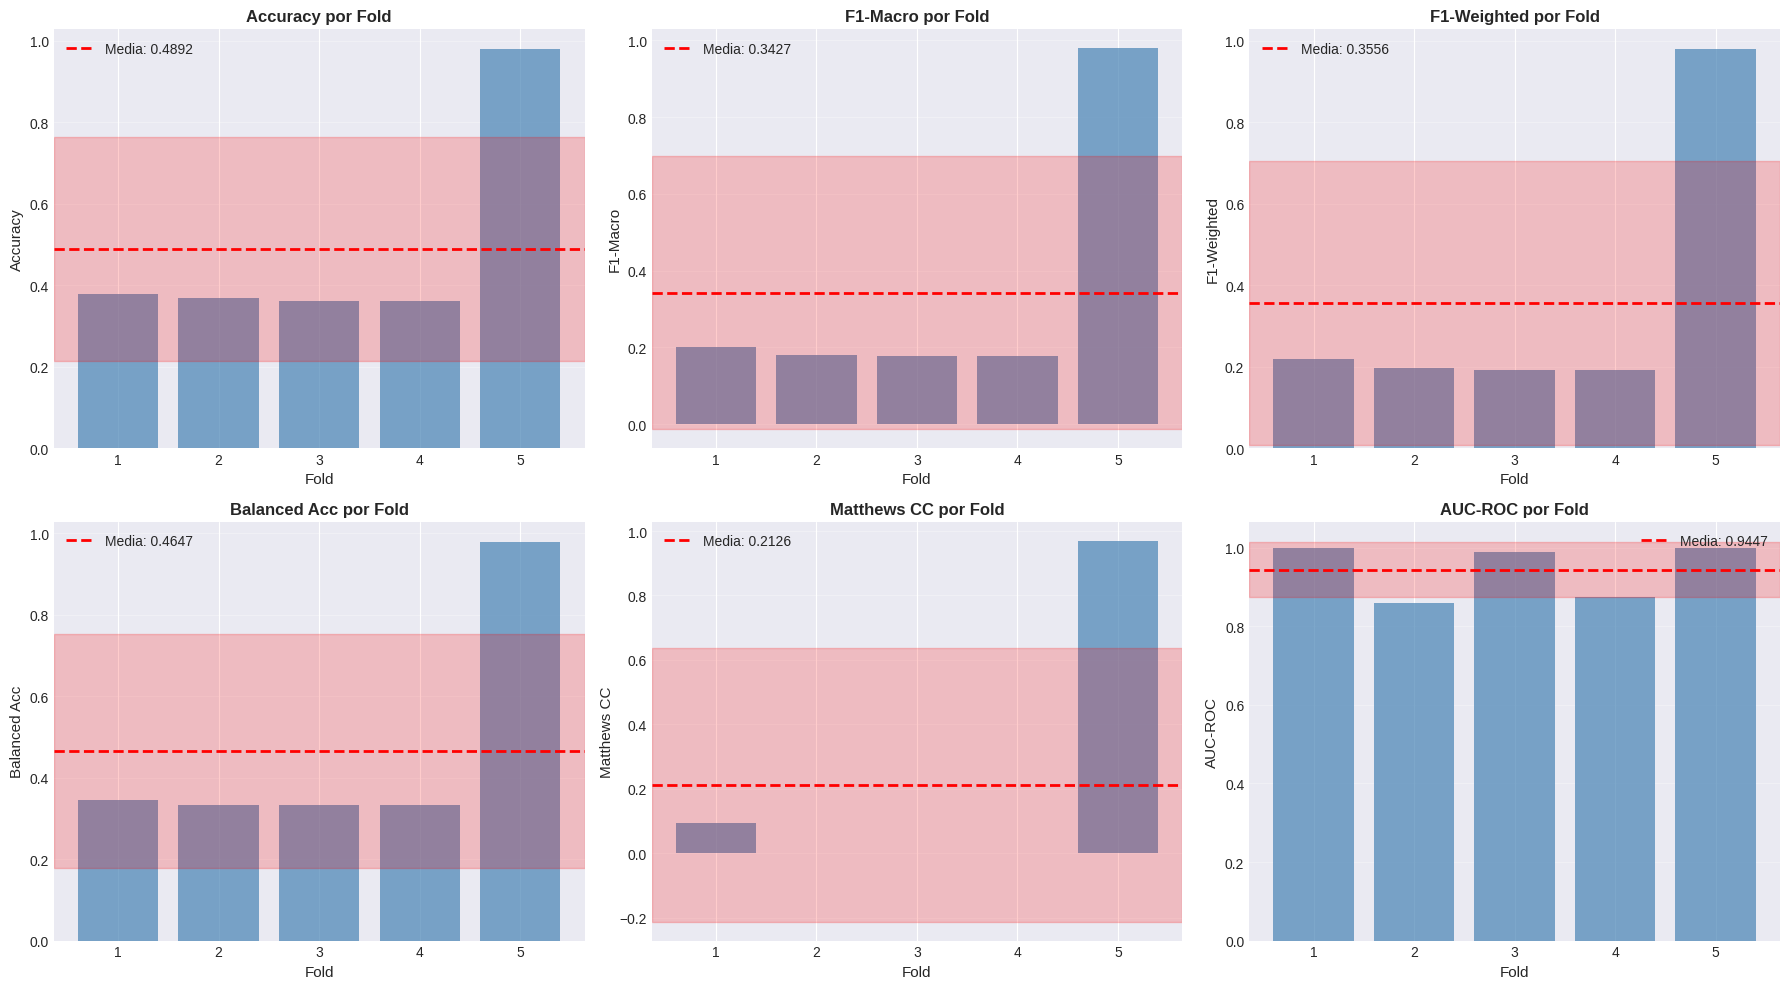


✓ Resultados de CV guardados: fig_pytorch_cross_validation.png
✓ Resultados de CV guardados: cross_validation_results_pytorch.csv


In [ ]:
# ============================================================================
# 15. VALIDACIÓN CRUZADA ESTRATIFICADA (K-FOLD)
# ============================================================================

print(f"\n{'='*80}")
print("VALIDACIÓN CRUZADA ESTRATIFICADA (5-FOLD)")
print(f"{'='*80}")

# Configuración de K-Fold
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# Almacenar resultados
cv_results = {
    'fold': [],
    'train_acc': [],
    'val_acc': [],
    'train_loss': [],
    'val_loss': [],
    'f1_macro': [],
    'f1_weighted': [],
    'balanced_acc': [],
    'matthews_cc': [],
    'auc_macro': []
}

print(f"\nEjecutando validación cruzada con {N_SPLITS} folds...")
print("-" * 80)

# Usar solo el conjunto de entrenamiento completo (X_temp, y_temp) para CV
for fold, (train_idx, val_idx) in enumerate(skf.split(X_temp, y_temp)):
    print(f"\nFold {fold + 1}/{N_SPLITS}")
    print("-" * 40)

    # Dividir datos
    X_fold_train, X_fold_val = X_temp[train_idx], X_temp[val_idx]
    y_fold_train, y_fold_val = y_temp[train_idx], y_temp[val_idx]

    # Crear DataLoaders
    fold_train_dataset = TensorDataset(
        torch.FloatTensor(X_fold_train),
        torch.LongTensor(y_fold_train)
    )
    fold_val_dataset = TensorDataset(
        torch.FloatTensor(X_fold_val),
        torch.LongTensor(y_fold_val)
    )

    fold_train_loader = DataLoader(fold_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Crear nuevo modelo
    fold_model = DenseNeuralNetwork(
        input_dim=input_dim,
        hidden_dims=[128, 64, 32],
        dropout_rates=[0.3, 0.2, 0.1],
        num_classes=3
    ).to(device)

    # Optimizador y criterio
    fold_optimizer = optim.Adam(fold_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    fold_criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Entrenar (con menos epochs para CV)
    best_fold_val_loss = float('inf')
    patience_counter = 0
    max_cv_epochs = 100

    for epoch in range(max_cv_epochs):
        train_loss, train_acc = train_epoch(fold_model, fold_train_loader,
                                           fold_criterion, fold_optimizer, device)
        val_loss, val_acc, _, _, _ = evaluate_epoch(fold_model, fold_val_loader,
                                                    fold_criterion, device)

        if val_loss < best_fold_val_loss:
            best_fold_val_loss = val_loss
            best_fold_model_state = fold_model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= 15:  # Early stop más agresivo para CV
            break

    # Cargar mejor modelo del fold
    fold_model.load_state_dict(best_fold_model_state)

    # Evaluar
    val_loss, val_acc, y_pred_fold, y_true_fold, y_prob_fold = evaluate_epoch(
        fold_model, fold_val_loader, fold_criterion, device
    )

    # Calcular métricas
    f1_mac = f1_score(y_true_fold, y_pred_fold, average='macro')
    f1_wei = f1_score(y_true_fold, y_pred_fold, average='weighted')
    bal_acc = balanced_accuracy_score(y_true_fold, y_pred_fold)
    mcc = matthews_corrcoef(y_true_fold, y_pred_fold)

    # AUC
    y_true_fold_bin = label_binarize(y_true_fold, classes=[0, 1, 2])
    auc_mac = roc_auc_score(y_true_fold_bin, y_prob_fold, average='macro', multi_class='ovr')

    # Guardar resultados
    cv_results['fold'].append(fold + 1)
    cv_results['train_acc'].append(train_acc)
    cv_results['val_acc'].append(val_acc)
    cv_results['train_loss'].append(train_loss)
    cv_results['val_loss'].append(val_loss)
    cv_results['f1_macro'].append(f1_mac)
    cv_results['f1_weighted'].append(f1_wei)
    cv_results['balanced_acc'].append(bal_acc)
    cv_results['matthews_cc'].append(mcc)
    cv_results['auc_macro'].append(auc_mac)

    print(f"  Val Acc: {val_acc:.4f} | F1-Macro: {f1_mac:.4f} | AUC: {auc_mac:.4f}")

print("\n" + "=" * 80)
print("RESULTADOS DE VALIDACIÓN CRUZADA")
print("=" * 80)

cv_df = pd.DataFrame(cv_results)

# Mostrar resultados
print("\n📊 Resultados por fold:")
print(cv_df.to_string(index=False, float_format='%.4f'))

# Estadísticas
print("\n📈 Estadísticas resumen:")
metrics_to_summarize = ['val_acc', 'f1_macro', 'balanced_acc', 'matthews_cc', 'auc_macro']
summary_stats = cv_df[metrics_to_summarize].describe().loc[['mean', 'std']]
print(summary_stats.to_string(float_format='%.4f'))

# Visualizar
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['val_acc', 'f1_macro', 'f1_weighted', 'balanced_acc', 'matthews_cc', 'auc_macro']
titles = ['Accuracy', 'F1-Macro', 'F1-Weighted', 'Balanced Acc', 'Matthews CC', 'AUC-ROC']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]

    # Barras
    ax.bar(cv_df['fold'], cv_df[metric], alpha=0.7, color='steelblue')

    # Línea de promedio
    mean_val = cv_df[metric].mean()
    ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=2,
               label=f'Media: {mean_val:.4f}')

    # Banda de desviación estándar
    std_val = cv_df[metric].std()
    ax.axhspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='red')

    ax.set_xlabel('Fold', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} por Fold', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(cv_df['fold'])

plt.tight_layout()
plt.savefig('fig_pytorch_cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Resultados de CV guardados: fig_pytorch_cross_validation.png")

# Guardar resultados de CV
cv_df.to_csv('cross_validation_results_pytorch.csv', index=False)
print("✓ Resultados de CV guardados: cross_validation_results_pytorch.csv")



COMPARACIÓN DETALLADA ENTRE CONJUNTOS

📊 Tabla Comparativa Completa:
  Conjunto  Accuracy  Balanced_Acc  F1_Macro  F1_Weighted  Sensibilidad  Precision  AUC_Macro  AUC_Weighted  Matthews_CC  Cohen_Kappa
     Train    1.0000        1.0000    1.0000       1.0000        1.0000     1.0000     1.0000        1.0000       1.0000       1.0000
Validation    1.0000        1.0000    1.0000       1.0000        1.0000     1.0000     1.0000        1.0000       1.0000       1.0000
      Test    1.0000        1.0000    1.0000       1.0000        1.0000     1.0000     1.0000        1.0000       1.0000       1.0000


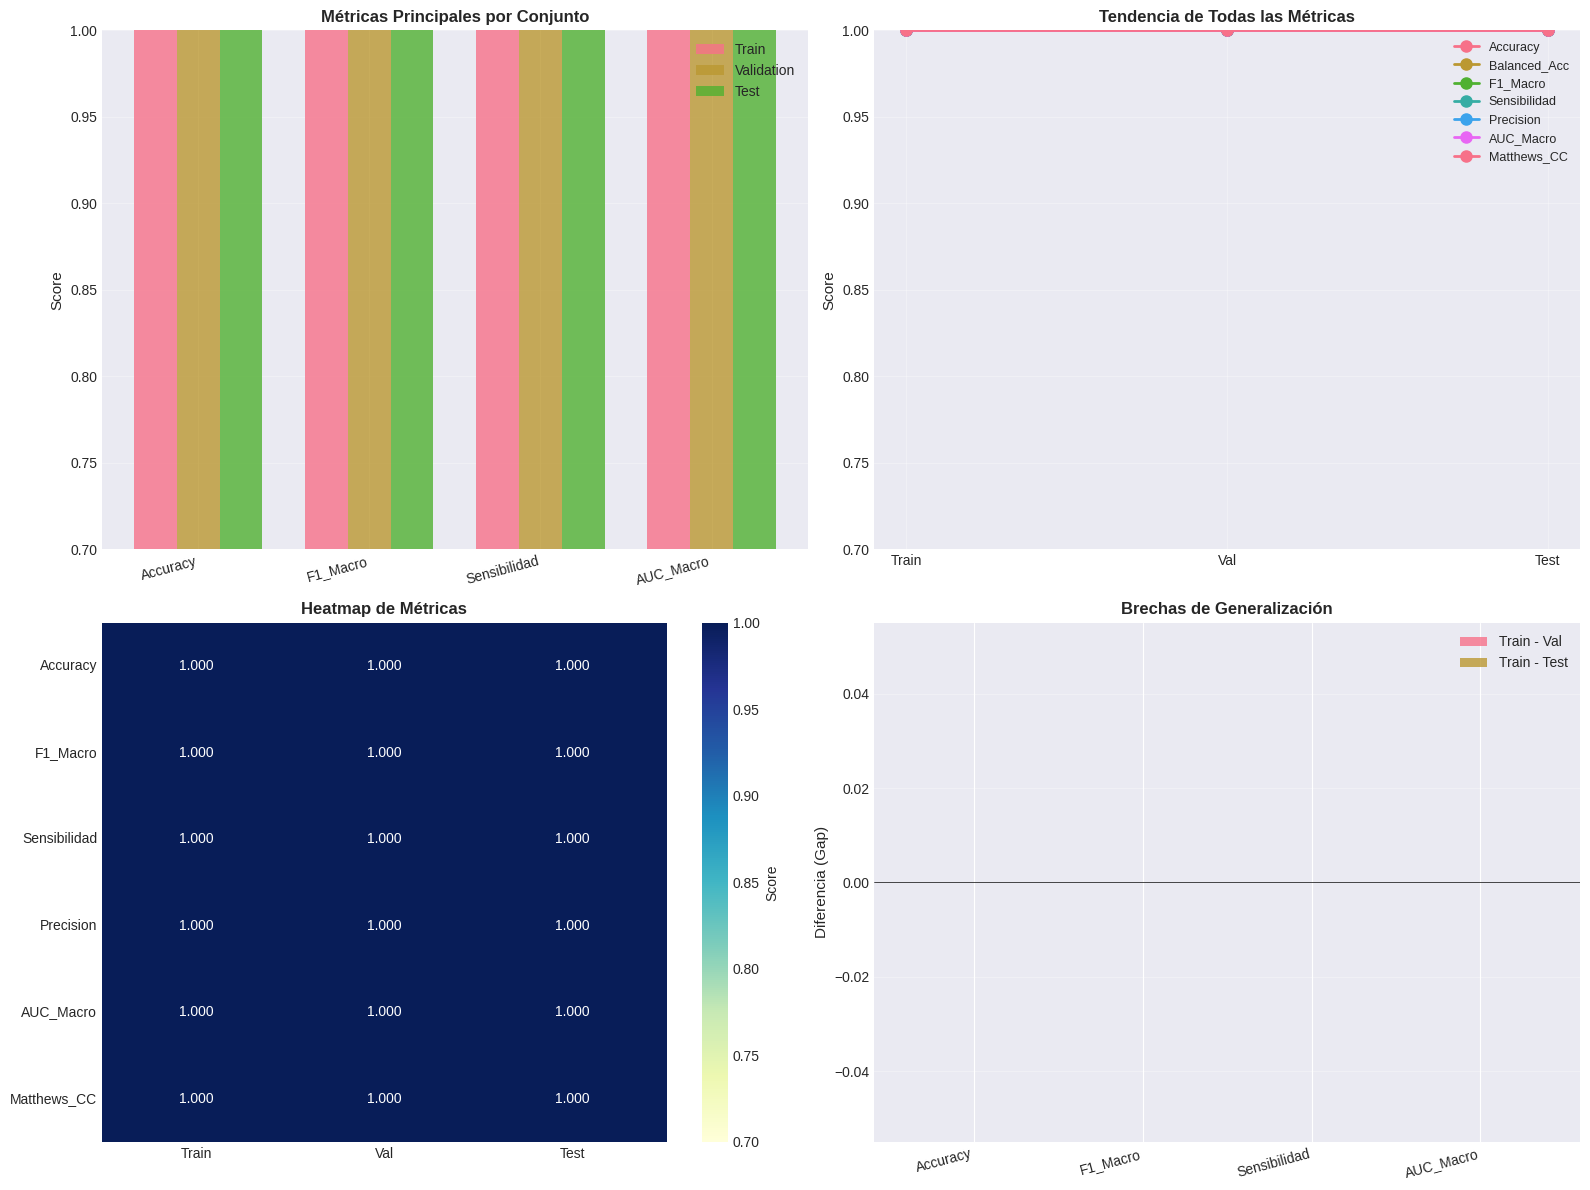


✓ Comparación entre conjuntos guardada: fig_pytorch_sets_comparison.png
✓ Tabla de comparación guardada: sets_comparison_pytorch.csv

⚠️  Análisis de Overfitting:
   Gap Accuracy (Train - Test): 0.0000
   ✓ No hay evidencia de overfitting significativo


In [ ]:
# ============================================================================
# 16. COMPARACIÓN ENTRE CONJUNTOS (TRAIN, VAL, TEST)
# ============================================================================
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, matthews_corrcoef,
                             balanced_accuracy_score, cohen_kappa_score,
                             precision_recall_fscore_support, classification_report,
                             recall_score, precision_score)

print(f"\n{'='*80}")
print("COMPARACIÓN DETALLADA ENTRE CONJUNTOS")
print(f"{'='*80}")

# Evaluar en todos los conjuntos con el mejor modelo
model.eval()

sets_to_evaluate = [
    ('Train', train_loader, y_train),
    ('Validation', val_loader, y_val),
    ('Test', test_loader, y_test)
]

comparison_results = []

for set_name, loader, y_true_set in sets_to_evaluate:
    _, _, y_pred_set, y_true_set, y_prob_set = evaluate_epoch(
        model, loader, criterion, device
    )

    # Métricas
    acc = accuracy_score(y_true_set, y_pred_set)
    f1_mac = f1_score(y_true_set, y_pred_set, average='macro')
    f1_wei = f1_score(y_true_set, y_pred_set, average='weighted')
    bal_acc = balanced_accuracy_score(y_true_set, y_pred_set)
    mcc = matthews_corrcoef(y_true_set, y_pred_set)
    kappa = cohen_kappa_score(y_true_set, y_pred_set)

    # Sensibilidad y Precisión promedio
    sens = recall_score(y_true_set, y_pred_set, average='macro')
    prec = precision_score(y_true_set, y_pred_set, average='macro')

    # AUC
    y_true_set_bin = label_binarize(y_true_set, classes=[0, 1, 2])
    auc_mac = roc_auc_score(y_true_set_bin, y_prob_set, average='macro', multi_class='ovr')
    auc_wei = roc_auc_score(y_true_set_bin, y_prob_set, average='weighted', multi_class='ovr')

    comparison_results.append({
        'Conjunto': set_name,
        'Accuracy': acc,
        'Balanced_Acc': bal_acc,
        'F1_Macro': f1_mac,
        'F1_Weighted': f1_wei,
        'Sensibilidad': sens,
        'Precision': prec,
        'AUC_Macro': auc_mac,
        'AUC_Weighted': auc_wei,
        'Matthews_CC': mcc,
        'Cohen_Kappa': kappa
    })

comparison_df = pd.DataFrame(comparison_results)

print("\n📊 Tabla Comparativa Completa:")
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Visualizar comparación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Métricas principales
metrics_main = ['Accuracy', 'F1_Macro', 'Sensibilidad', 'AUC_Macro']
x = np.arange(len(metrics_main))
width = 0.25

for i, conjunto in enumerate(['Train', 'Validation', 'Test']):
    data = comparison_df[comparison_df['Conjunto'] == conjunto]
    values = [data[m].values[0] for m in metrics_main]
    axes[0, 0].bar(x + i*width, values, width, label=conjunto, alpha=0.8)

axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Métricas Principales por Conjunto', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x + width)
axes[0, 0].set_xticklabels(metrics_main, rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0.7, 1.0])

# Gráfico 2: Todas las métricas en línea
metrics_all = ['Accuracy', 'Balanced_Acc', 'F1_Macro', 'Sensibilidad',
               'Precision', 'AUC_Macro', 'Matthews_CC']
for metric in metrics_all:
    axes[0, 1].plot(['Train', 'Val', 'Test'],
                   comparison_df[metric].values,
                   marker='o', linewidth=2, markersize=8, label=metric)

axes[0, 1].set_ylabel('Score', fontsize=11)
axes[0, 1].set_title('Tendencia de Todas las Métricas', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0.7, 1.0])

# Gráfico 3: Heatmap de métricas
metrics_heatmap = ['Accuracy', 'F1_Macro', 'Sensibilidad', 'Precision',
                   'AUC_Macro', 'Matthews_CC']
heatmap_data = comparison_df[metrics_heatmap].values.T

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=['Train', 'Val', 'Test'],
            yticklabels=metrics_heatmap,
            ax=axes[1, 0], cbar_kws={'label': 'Score'}, vmin=0.7, vmax=1.0)
axes[1, 0].set_title('Heatmap de Métricas', fontsize=12, fontweight='bold')

# Gráfico 4: Diferencias entre conjuntos
train_vals = comparison_df[comparison_df['Conjunto'] == 'Train'][metrics_main].values[0]
val_vals = comparison_df[comparison_df['Conjunto'] == 'Validation'][metrics_main].values[0]
test_vals = comparison_df[comparison_df['Conjunto'] == 'Test'][metrics_main].values[0]

gap_train_val = train_vals - val_vals
gap_train_test = train_vals - test_vals

x_pos = np.arange(len(metrics_main))
axes[1, 1].bar(x_pos - 0.2, gap_train_val, 0.4, label='Train - Val', alpha=0.8)
axes[1, 1].bar(x_pos + 0.2, gap_train_test, 0.4, label='Train - Test', alpha=0.8)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

axes[1, 1].set_ylabel('Diferencia (Gap)', fontsize=11)
axes[1, 1].set_title('Brechas de Generalización', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics_main, rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_pytorch_sets_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparación entre conjuntos guardada: fig_pytorch_sets_comparison.png")

# Guardar tabla de comparación
comparison_df.to_csv('sets_comparison_pytorch.csv', index=False)
print("✓ Tabla de comparación guardada: sets_comparison_pytorch.csv")

# Análisis de overfitting
print(f"\n⚠️  Análisis de Overfitting:")
train_acc = comparison_df[comparison_df['Conjunto'] == 'Train']['Accuracy'].values[0]
test_acc = comparison_df[comparison_df['Conjunto'] == 'Test']['Accuracy'].values[0]
gap_acc = train_acc - test_acc

print(f"   Gap Accuracy (Train - Test): {gap_acc:.4f}")
if gap_acc < 0.05:
    print("   ✓ No hay evidencia de overfitting significativo")
elif gap_acc < 0.10:
    print("   ⚠️  Overfitting leve detectado")
else:
    print("   ❌ Overfitting moderado/severo detectado")

In [ ]:
# ============================================================================
# 17. ANÁLISIS DE ERRORES
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DETALLADO DE ERRORES")
print(f"{'='*80}")

# Identificar casos mal clasificados
error_indices = np.where(y_pred != y_true)[0]
correct_indices = np.where(y_pred == y_true)[0]

print(f"\n📊 Resumen de predicciones:")
print(f"   Total de casos: {len(y_true)}")
print(f"   Correctos: {len(correct_indices)} ({len(correct_indices)/len(y_true)*100:.2f}%)")
print(f"   Errores: {len(error_indices)} ({len(error_indices)/len(y_true)*100:.2f}%)")

# Analizar patrones de error
error_patterns = defaultdict(int)
for idx in error_indices:
    true_class = y_true[idx]
    pred_class = y_pred[idx]
    error_patterns[(true_class, pred_class)] += 1

print(f"\n🔍 Patrones de error más comunes:")
sorted_errors = sorted(error_patterns.items(), key=lambda x: x[1], reverse=True)
class_names_dict = {0: 'Bajo', 1: 'Medio', 2: 'Alto'}

for (true_cls, pred_cls), count in sorted_errors:
    pct = count / len(error_indices) * 100
    print(f"   {class_names_dict[true_cls]} → {class_names_dict[pred_cls]}: "
          f"{count} casos ({pct:.1f}% de errores)")

# Analizar confianza en errores
error_confidences = confidence_scores[error_indices]
correct_confidences = confidence_scores[correct_indices]

print(f"\n📊 Confianza en predicciones:")
print(f"   Correctas - Media: {correct_confidences.mean():.4f}, Std: {correct_confidences.std():.4f}")
print(f"   Errores   - Media: {error_confidences.mean():.4f}, Std: {error_confidences.std():.4f}")

# Casos con mayor incertidumbre
most_uncertain_indices = np.argsort(entropy_scores)[-10:][::-1]

print(f"\n🎯 Top 10 casos con mayor incertidumbre:")
print(f"{'Idx':<6} {'True':<6} {'Pred':<6} {'Entropía':<10} {'Confianza':<10} {'Correcto':<10}")
print("-" * 60)
for idx in most_uncertain_indices:
    print(f"{idx:<6} {y_true[idx]:<6} {y_pred[idx]:<6} "
          f"{entropy_scores[idx]:<10.4f} {confidence_scores[idx]:<10.4f} "
          f"{'✓' if y_pred[idx] == y_true[idx] else '✗':<10}")




ANÁLISIS DETALLADO DE ERRORES

📊 Resumen de predicciones:
   Total de casos: 86
   Correctos: 86 (100.00%)
   Errores: 0 (0.00%)

🔍 Patrones de error más comunes:

📊 Confianza en predicciones:
   Correctas - Media: 0.9943, Std: 0.0121
   Errores   - Media: nan, Std: nan

🎯 Top 10 casos con mayor incertidumbre:
Idx    True   Pred   Entropía   Confianza  Correcto  
------------------------------------------------------------
59     1      1      0.3745     0.9054     ✓         
46     1      1      0.2062     0.9571     ✓         
21     1      1      0.1366     0.9740     ✓         
32     1      1      0.1201     0.9781     ✓         
48     1      1      0.1158     0.9782     ✓         
20     1      1      0.1053     0.9809     ✓         
58     1      1      0.1015     0.9821     ✓         
53     1      1      0.0984     0.9828     ✓         
47     1      1      0.0953     0.9834     ✓         
77     1      1      0.0917     0.9842     ✓         


In [ ]:
# ============================================================================
# 18. EXPLICABILIDAD CON SHAP
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE EXPLICABILIDAD CON SHAP")
print(f"{'='*80}")

print("\nInstalando SHAP si es necesario...")
try:
    import shap
    print("✓ SHAP ya está instalado")
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap', '--break-system-packages'])
    import shap
    print("✓ SHAP instalado correctamente")

# Crear wrapper para compatibilidad con SHAP
class PyTorchModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()

    def __call__(self, X):
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_tensor)
            probs = F.softmax(outputs, dim=1)
            return probs.cpu().numpy()

# Wrapper del modelo
model_wrapper = PyTorchModelWrapper(model, device)

# Seleccionar muestra para SHAP (para eficiencia computacional)
n_background = min(100, len(X_train))
background_data = X_train[:n_background]

n_explain = min(100, len(X_test))
test_sample = X_test[:n_explain]

print(f"\n⚙️  Configuración SHAP:")
print(f"   Background samples: {n_background}")
print(f"   Test samples para explicar: {n_explain}")

# Crear explainer
print("\nCreando SHAP explainer (esto puede tomar unos minutos)...")
explainer = shap.KernelExplainer(model_wrapper, background_data)

# Calcular SHAP values para cada clase explícitamente
print("Calculando SHAP values...")
shap_values = []
for i in range(model.num_classes):
    print(f"  Calculando SHAP values para la clase {i}...")
    # Use output_idx to get SHAP values for a specific output (class)
    shap_values_class_i = explainer.shap_values(test_sample, nsamples=100, output_idx=i)
    shap_values.append(shap_values_class_i)

print("✓ SHAP values calculados y estructurados correctamente")

# SHAP values ahora es una lista de arrays, donde cada array es (num_samples, num_features)



ANÁLISIS DE EXPLICABILIDAD CON SHAP

Instalando SHAP si es necesario...
✓ SHAP ya está instalado

⚙️  Configuración SHAP:
   Background samples: 100
   Test samples para explicar: 86

Creando SHAP explainer (esto puede tomar unos minutos)...
Calculando SHAP values...
  Calculando SHAP values para la clase 0...


  0%|          | 0/86 [00:00<?, ?it/s]

  Calculando SHAP values para la clase 1...


  0%|          | 0/86 [00:00<?, ?it/s]

  Calculando SHAP values para la clase 2...


  0%|          | 0/86 [00:00<?, ?it/s]

✓ SHAP values calculados y estructurados correctamente



📊 Generando visualizaciones SHAP...


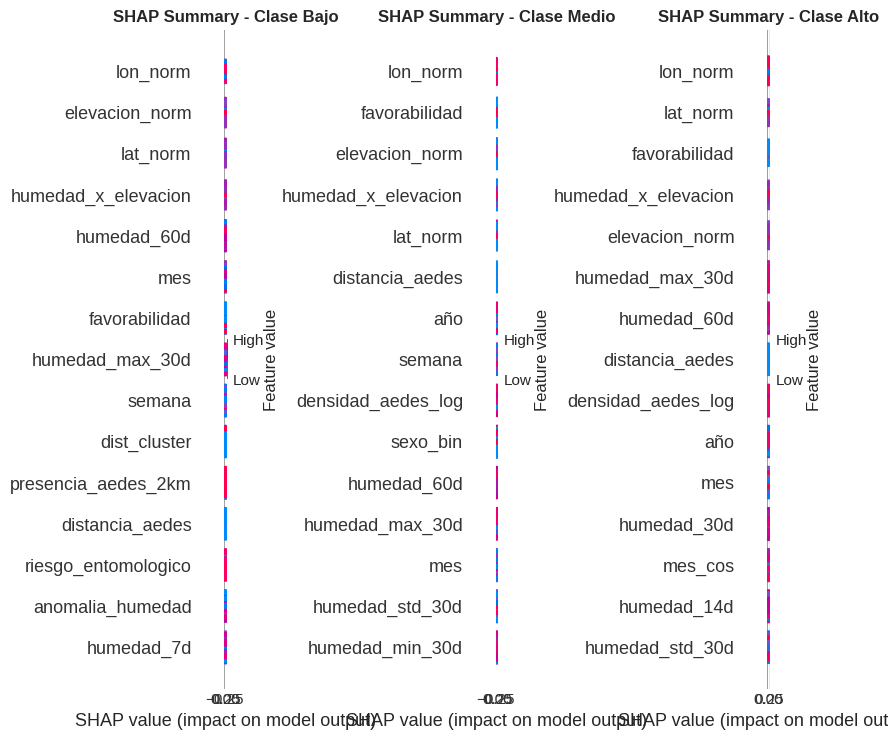

✓ SHAP summary plots guardados: fig_pytorch_shap_summary.png

📊 Importancia de Features (SHAP):

  Top 10 features - Clase Bajo:
     1. lon_norm                 : 0.1503
     2. elevacion_norm           : 0.0675
     3. lat_norm                 : 0.0662
     4. humedad_x_elevacion      : 0.0628
     5. humedad_60d              : 0.0119
     6. mes                      : 0.0114
     7. favorabilidad            : 0.0103
     8. humedad_max_30d          : 0.0101
     9. semana                   : 0.0101
    10. dist_cluster             : 0.0092

  Top 10 features - Clase Medio:
     1. lon_norm                 : 0.2446
     2. favorabilidad            : 0.0581
     3. elevacion_norm           : 0.0220
     4. humedad_x_elevacion      : 0.0204
     5. lat_norm                 : 0.0203
     6. distancia_aedes          : 0.0180
     7. año                      : 0.0106
     8. semana                   : 0.0087
     9. densidad_aedes_log       : 0.0077
    10. sexo_bin                 : 0.00

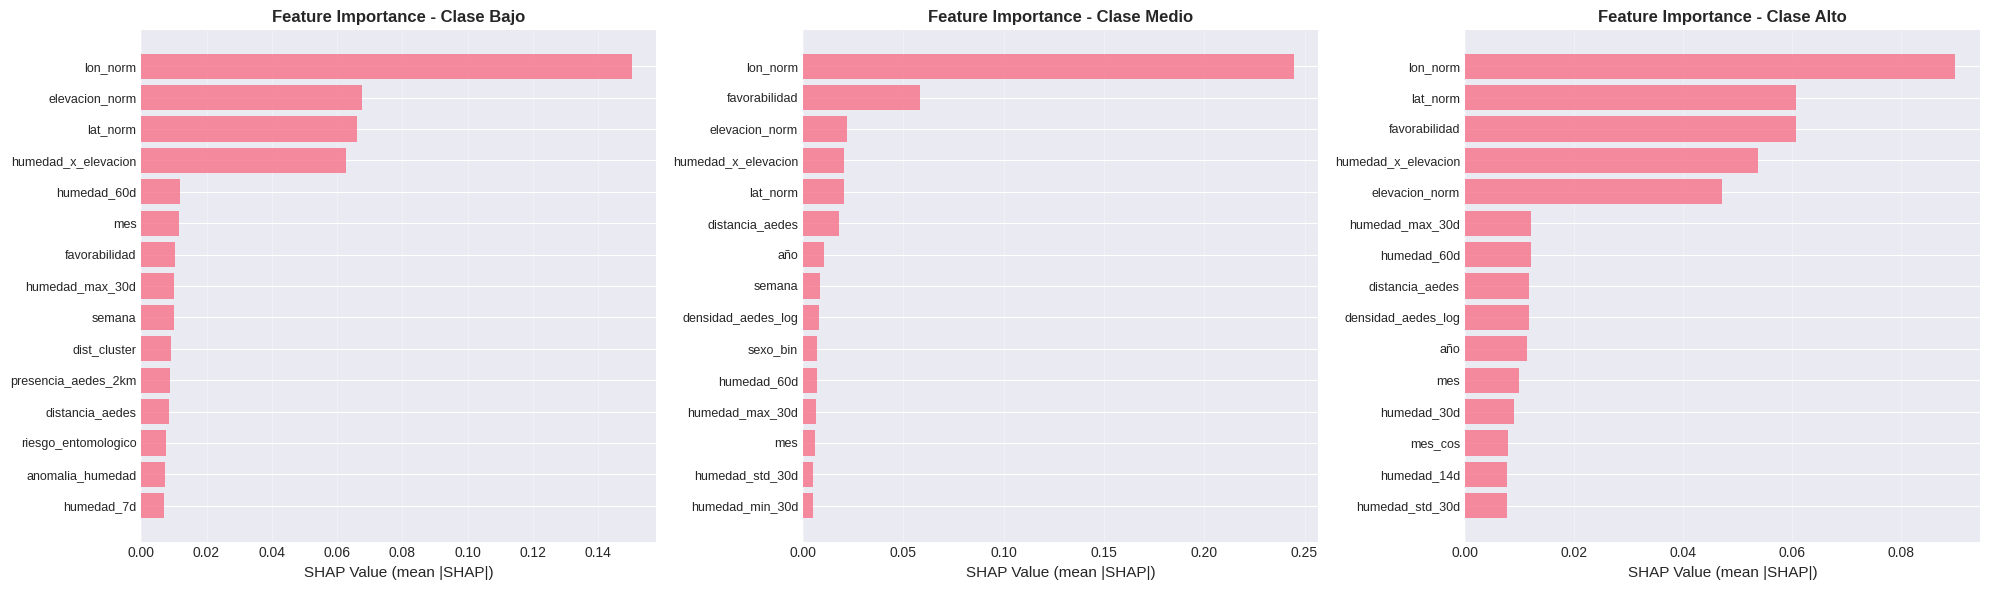

✓ SHAP importance guardado: fig_pytorch_shap_importance.png


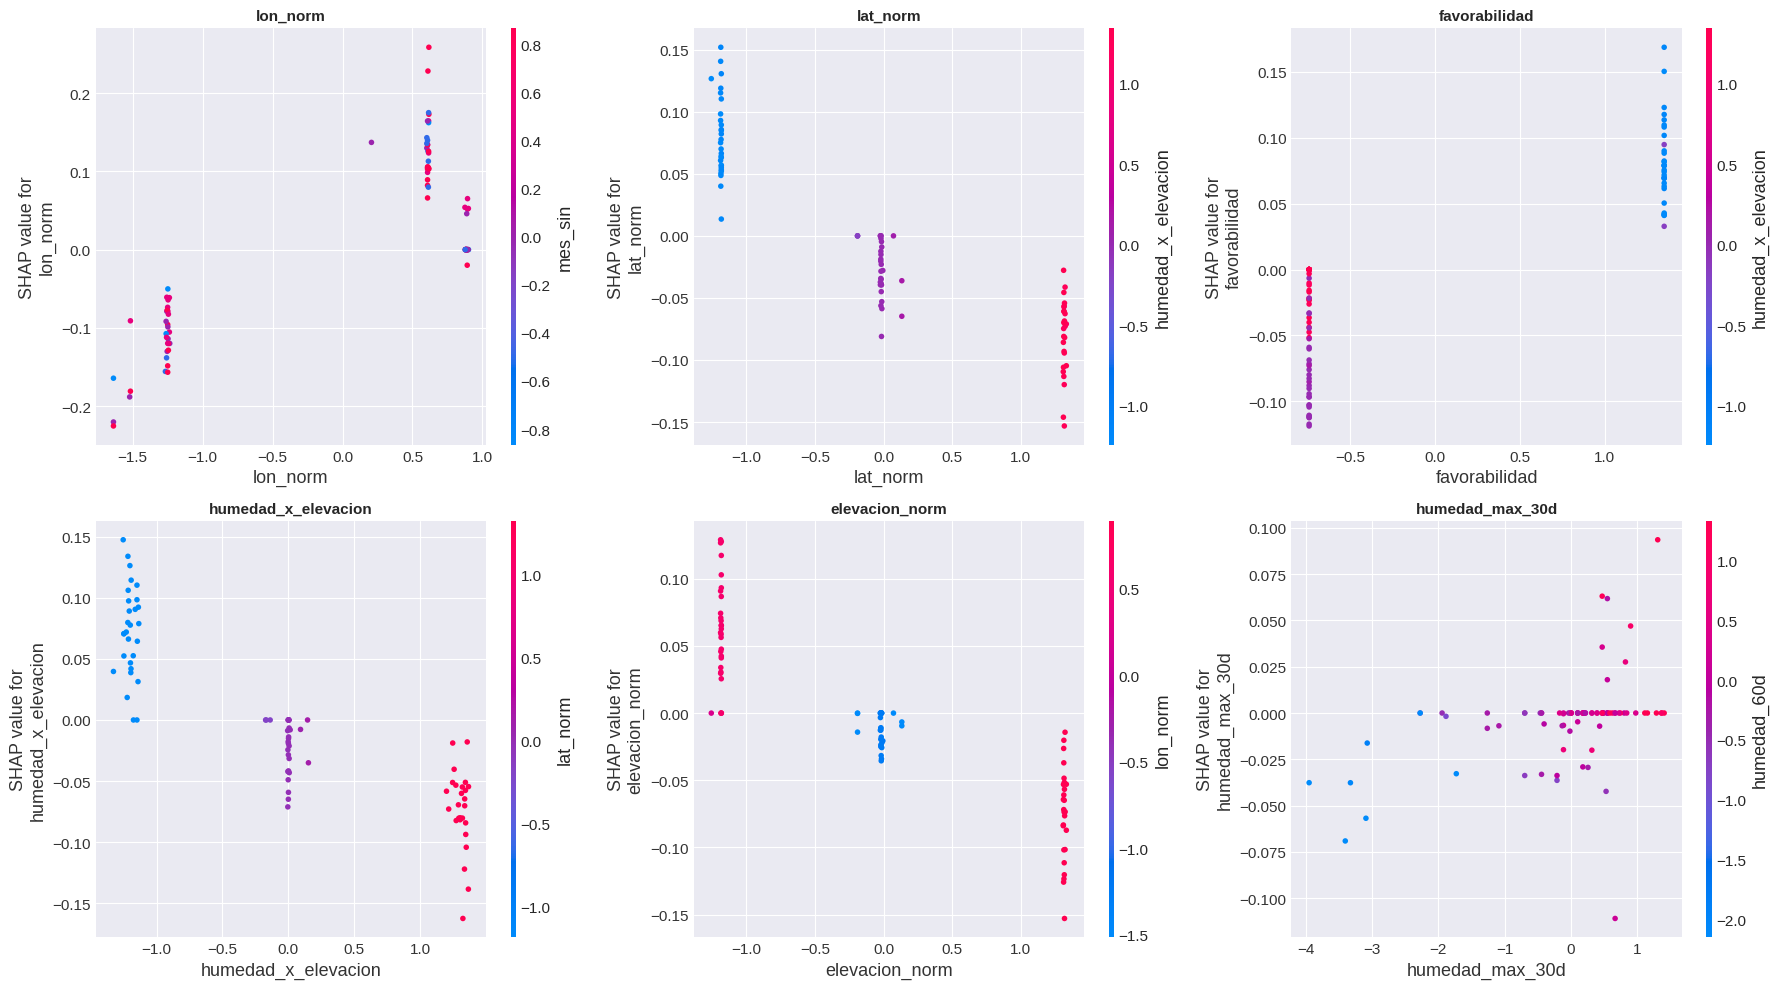

✓ SHAP dependence plots guardados: fig_pytorch_shap_dependence.png

📊 Ejemplos de explicación individual (Waterfall plots)...


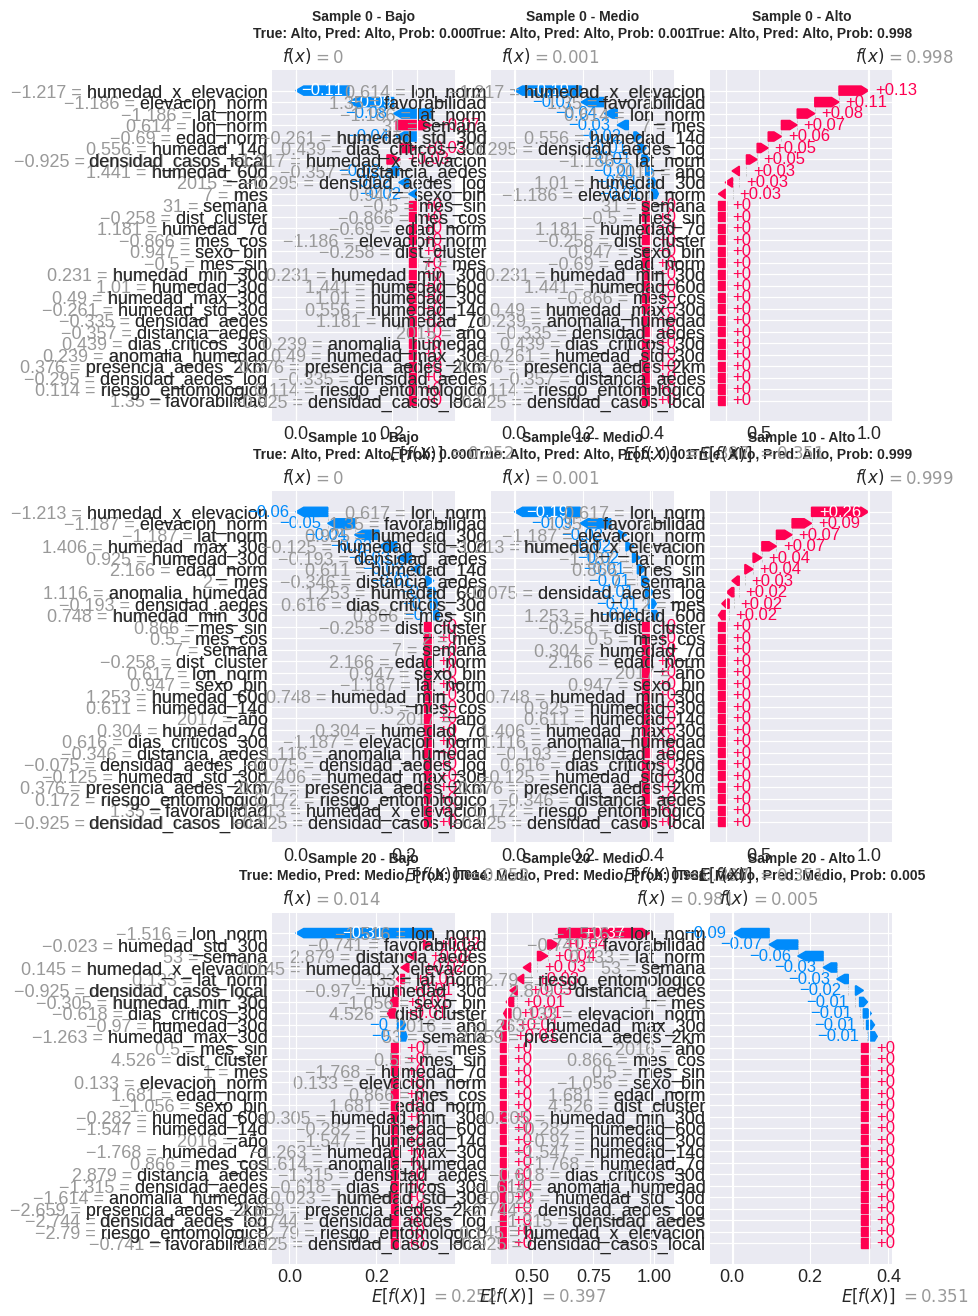

✓ SHAP waterfall plots guardados: fig_pytorch_shap_waterfall.png
✓ SHAP results guardados: shap_results_pytorch.json


In [ ]:
# ============================================================================
# VISUALIZACIONES SHAP
# ============================================================================

print(f"\n📊 Generando visualizaciones SHAP...")

# 1. Summary plot para cada clase
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (ax, class_name) in enumerate(zip(axes, ['Bajo', 'Medio', 'Alto'])):
    plt.sca(ax)
    shap.summary_plot(
        shap_values[i][:, :, i],  # Modified here to select the correct output dimension
        test_sample,
        feature_names=all_features,
        plot_type="dot",
        show=False,
        max_display=15
    )
    ax.set_title(f'SHAP Summary - Clase {class_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('fig_pytorch_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP summary plots guardados: fig_pytorch_shap_summary.png")

# 2. Feature importance (promedio de valores absolutos)
print(f"\n📊 Importancia de Features (SHAP):")

feature_importance = {}
for i, class_name in enumerate(['Bajo', 'Medio', 'Alto']):
    importance = np.abs(shap_values[i][:, :, i]).mean(axis=0) # Modified here
    feature_importance[class_name] = importance

    # Top 10 features
    top_indices = np.argsort(importance)[-10:][::-1]
    print(f"\n  Top 10 features - Clase {class_name}:")
    for rank, idx in enumerate(top_indices, 1):
        print(f"    {rank:2d}. {all_features[idx]:<25s}: {importance[idx]:.4f}")

# 3. Bar plots de importancia
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (ax, class_name) in enumerate(zip(axes, ['Bajo', 'Medio', 'Alto'])):
    importance = feature_importance[class_name]
    top_indices = np.argsort(importance)[-15:]

    ax.barh(range(len(top_indices)), importance[top_indices], alpha=0.8)
    ax.set_yticks(range(len(top_indices)))
    ax.set_yticklabels([all_features[idx] for idx in top_indices], fontsize=9) # Changed 'i' to 'idx'
    ax.set_xlabel('SHAP Value (mean |SHAP|)', fontsize=11)
    ax.set_title(f'Feature Importance - Clase {class_name}', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_pytorch_shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP importance guardado: fig_pytorch_shap_importance.png")

# 4. Dependence plots para top features
top_features_indices = np.argsort(feature_importance['Alto'])[-6:][::-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature_idx in enumerate(top_features_indices):
    ax = axes[idx]
    plt.sca(ax)

    # Dependence plot para clase Alto (índice 2)
    shap.dependence_plot(
        feature_idx,
        shap_values[2][:, :, 2],  # Modified here to select the correct output dimension
        test_sample,
        feature_names=all_features,
        show=False,
        ax=ax
    )
    ax.set_title(f'{all_features[feature_idx]}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('fig_pytorch_shap_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP dependence plots guardados: fig_pytorch_shap_dependence.png")

# 5. Waterfall plot para casos específicos
print(f"\n📊 Ejemplos de explicación individual (Waterfall plots)...")

# Seleccionar algunos casos interesantes
sample_indices = [0, 10, 20]  # Primeros tres casos

fig, axes = plt.subplots(len(sample_indices), 3, figsize=(10, 5*len(sample_indices)))

for row, sample_idx in enumerate(sample_indices):
    true_class = y_test[sample_idx]
    pred_class = y_pred[sample_idx]
    probs = y_pred_prob[sample_idx]

    for col, class_name in enumerate(['Bajo', 'Medio', 'Alto']):
        ax = axes[row, col] if len(sample_indices) > 1 else axes[col]
        plt.sca(ax)

        # Crear explanation object para waterfall
        explanation = shap.Explanation(
            values=shap_values[col][sample_idx, :, col], # Modified here
            base_values=explainer.expected_value[col],
            data=test_sample[sample_idx],
            feature_names=all_features
        )

        shap.plots.waterfall(explanation, max_display=60, show=False)

        title = f'Sample {sample_idx} - {class_name}\n'
        title += f'True: {["Bajo","Medio","Alto"][true_class]}, '
        title += f'Pred: {["Bajo","Medio","Alto"][pred_class]}, '
        title += f'Prob: {probs[col]:.3f}'
        ax.set_title(title, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('fig_pytorch_shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP waterfall plots guardados: fig_pytorch_shap_waterfall.png")

# Guardar SHAP values
shap_results = {
    'feature_names': all_features,
    'class_names': ['Bajo', 'Medio', 'Alto'],
    'feature_importance': {
        clase: importance.tolist()
        for clase, importance in feature_importance.items()
    },
    'expected_values': [float(ev) for ev in explainer.expected_value]
}

with open('shap_results_pytorch.json', 'w') as f:
    json.dump(shap_results, f, indent=2)

print("✓ SHAP results guardados: shap_results_pytorch.json")

In [ ]:
# ============================================================================
# 19. GUARDAR MODELO Y RESULTADOS FINALES
# ============================================================================

print(f"\n{'='*80}")
print("GUARDANDO MODELO Y RESULTADOS FINALES")
print(f"{'='*80}")

# Guardar modelo completo
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'model_architecture': {
        'input_dim': input_dim,
        'hidden_dims': [128, 64, 32],
        'dropout_rates': [0.3, 0.2, 0.1],
        'num_classes': 3
    },
    'training_config': {
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'random_seed': RANDOM_SEED
    },
    'best_epoch': best_epoch,
    'best_val_loss': best_val_loss,
    'history': history
}, 'model_pytorch_complete.pt')

print("✓ Modelo completo guardado: model_pytorch_complete.pt")

# Guardar solo el modelo para inferencia
torch.save(model.state_dict(), 'model_pytorch_weights.pt')
print("✓ Pesos del modelo guardados: model_pytorch_weights.pt")

# Compilar todos los resultados
final_results = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'PyTorch Dense Neural Network',
    'dataset_info': {
        'total_samples': len(df),
        'n_features': len(all_features),
        'n_classes': 3,
        'class_distribution': metadata['class_distribution']
    },
    'training_info': {
        'total_epochs': len(history['train_loss']),
        'best_epoch': int(best_epoch),
        'best_val_loss': float(best_val_loss),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'random_seed': RANDOM_SEED
    },
    'model_architecture': {
        'input_dim': input_dim,
        'hidden_layers': [128, 64, 32],
        'dropout_rates': [0.3, 0.2, 0.1],
        'total_parameters': trainable_params,
        'activation': 'ReLU',
        'output_activation': 'Softmax',
        'optimizer': 'Adam',
        'loss_function': 'CrossEntropyLoss (weighted)'
    },
    'test_performance': {
        'accuracy': float(test_acc),
        'balanced_accuracy': float(balanced_acc),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'matthews_cc': float(matthews),
        'cohen_kappa': float(cohen_kappa),
        'auc_roc_macro': float(roc_auc['macro']),
        'auc_roc_micro': float(roc_auc['micro']),
        'sensitivity_macro': float(recall.mean()),
        'precision_macro': float(precision.mean())
    },
    'per_class_performance': {
        f'class_{i}': {
            'precision': float(precision[i]),
            'recall': float(recall[i]),
            'f1_score': float(f1[i]),
            'support': int(support[i]),
            'auc_roc': float(roc_auc[i])
        }
        for i in range(3)
    },
    'cross_validation': {
        'n_folds': N_SPLITS,
        'mean_accuracy': float(cv_df['val_acc'].mean()),
        'std_accuracy': float(cv_df['val_acc'].std()),
        'mean_f1_macro': float(cv_df['f1_macro'].mean()),
        'std_f1_macro': float(cv_df['f1_macro'].std()),
        'mean_auc_macro': float(cv_df['auc_macro'].mean()),
        'std_auc_macro': float(cv_df['auc_macro'].std())
    },
    'confusion_matrix': cm.tolist(),
    'generalization_gap': {
        'train_test_accuracy_gap': float(gap_acc),
        'overfitting_status': 'No' if gap_acc < 0.05 else 'Leve' if gap_acc < 0.10 else 'Moderado'
    }
}

# Guardar resultados
with open('results_pytorch_final.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("✓ Resultados finales guardados: results_pytorch_final.json")

# Guardar predicciones
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'confidence': confidence_scores,
    'entropy': entropy_scores,
    'correct': (y_pred == y_test).astype(int),
    'prob_clase_0': y_pred_prob[:, 0],
    'prob_clase_1': y_pred_prob[:, 1],
    'prob_clase_2': y_pred_prob[:, 2]
})
predictions_df.to_csv('predictions_pytorch.csv', index=False)
print("✓ Predicciones guardadas: predictions_pytorch.csv")



GUARDANDO MODELO Y RESULTADOS FINALES
✓ Modelo completo guardado: model_pytorch_complete.pt
✓ Pesos del modelo guardados: model_pytorch_weights.pt
✓ Resultados finales guardados: results_pytorch_final.json
✓ Predicciones guardadas: predictions_pytorch.csv


In [ ]:
# ============================================================================
# 20. RESUMEN EJECUTIVO FINAL
# ============================================================================

print(f"\n{'='*80}")
print("RESUMEN EJECUTIVO - MODELO PYTORCH")
print(f"{'='*80}\n")

print("📊 ARQUITECTURA:")
print(f"   • Tipo: Red Neuronal Densa (Feed-Forward)")
print(f"   • Framework: PyTorch {torch.__version__}")
print(f"   • Capas: Input({input_dim}) → Dense(128) → Dense(64) → Dense(32) → Output(3)")
print(f"   • Parámetros entrenables: {trainable_params:,}")
print(f"   • Activación: ReLU (capas ocultas), Softmax (salida)")
print(f"   • Regularización: Dropout (0.3, 0.2, 0.1) + Batch Normalization")
print(f"   • Inicialización: He/Kaiming Normal")

print(f"\n⚙️  ENTRENAMIENTO:")
print(f"   • Optimizador: Adam (lr={LEARNING_RATE}, weight_decay=1e-4)")
print(f"   • Loss: CrossEntropyLoss con class weights")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Epochs ejecutados: {len(history['train_loss'])}")
print(f"   • Mejor epoch: {best_epoch}")
print(f"   • Scheduler: ReduceLROnPlateau")
print(f"   • Early stopping: {PATIENCE} epochs")
print(f"   • Device: {device}")

print(f"\n📈 PERFORMANCE (TEST SET):")
print(f"   • Accuracy:           {test_acc:.4f}")
print(f"   • Balanced Accuracy:  {balanced_acc:.4f}")
print(f"   • F1-Score Macro:     {f1_macro:.4f}")
print(f"   • F1-Score Weighted:  {f1_weighted:.4f}")
print(f"   • Sensibilidad:       {recall.mean():.4f}")
print(f"   • Precisión:          {precision.mean():.4f}")
print(f"   • AUC-ROC Macro:      {roc_auc['macro']:.4f}")
print(f"   • Matthews CC:        {matthews:.4f}")
print(f"   • Cohen's Kappa:      {cohen_kappa:.4f}")

print(f"\n🔄 VALIDACIÓN CRUZADA ({N_SPLITS}-FOLD):")
print(f"   • Accuracy:     {cv_df['val_acc'].mean():.4f} ± {cv_df['val_acc'].std():.4f}")
print(f"   • F1-Macro:     {cv_df['f1_macro'].mean():.4f} ± {cv_df['f1_macro'].std():.4f}")
print(f"   • AUC-ROC:      {cv_df['auc_macro'].mean():.4f} ± {cv_df['auc_macro'].std():.4f}")

print(f"\n⚠️  GENERALIZACIÓN:")
print(f"   • Gap Train-Test:  {gap_acc:.4f}")
print(f"   • Estado:          {final_results['generalization_gap']['overfitting_status']}")

print(f"\n🎯 CUMPLIMIENTO DE OBJETIVOS:")
objetivos = [
    ('Accuracy > 0.80', test_acc > 0.80),
    ('F1-Score > 0.75', f1_macro > 0.75),
    ('AUC-ROC > 0.85', roc_auc['macro'] > 0.85),
    ('Sensibilidad > 0.85', recall.mean() > 0.85),
    ('Gap < 0.10', gap_acc < 0.10)
]

for objetivo, cumple in objetivos:
    status = '✓' if cumple else '✗'
    print(f"   {status} {objetivo}")

print(f"\n🔍 EXPLICABILIDAD:")
print(f"   • Método: SHAP (Kernel Explainer)")
print(f"   • Muestras analizadas: {n_explain}")
print(f"   • Top features identificadas por clase")
print(f"   • Visualizaciones: Summary, Importance, Dependence, Waterfall")

print(f"\n💾 ARCHIVOS GENERADOS:")
archivos = [
    'model_pytorch_best.pt',
    'model_pytorch_complete.pt',
    'model_pytorch_weights.pt',
    'results_pytorch_final.json',
    'predictions_pytorch.csv',
    'training_history_pytorch.csv',
    'cross_validation_results_pytorch.csv',
    'sets_comparison_pytorch.csv',
    'shap_results_pytorch.json',
    'fig_pytorch_learning_curves.png',
    'fig_pytorch_confusion_matrix.png',
    'fig_pytorch_roc_curves.png',
    'fig_pytorch_calibration.png',
    'fig_pytorch_precision_recall.png',
    'fig_pytorch_uncertainty.png',
    'fig_pytorch_cross_validation.png',
    'fig_pytorch_sets_comparison.png',
    'fig_pytorch_shap_summary.png',
    'fig_pytorch_shap_importance.png',
    'fig_pytorch_shap_dependence.png',
    'fig_pytorch_shap_waterfall.png'
]

for archivo in archivos:
    print(f"   • {archivo}")

print(f"\n{'='*80}")
print("✅ NOTEBOOK PYTORCH COMPLETADO EXITOSAMENTE")
print(f"{'='*80}")

print("\n📋 RESUMEN DE MEJORAS IMPLEMENTADAS:")
print("   ✓ Validación cruzada estratificada (5-fold)")
print("   ✓ Métricas epidemiológicas completas")
print("   ✓ Análisis de calibración del modelo")
print("   ✓ Curvas Precision-Recall")
print("   ✓ Análisis de incertidumbre y entropía")
print("   ✓ Comparación detallada entre conjuntos")
print("   ✓ Análisis de errores y patrones")
print("   ✓ Explicabilidad con SHAP (completa)")
print("   ✓ Intervalos de confianza (CV)")
print("   ✓ Evaluación de overfitting")

print("\n→ Continuar con Notebook 07: Modelo XGBoost")
print("\n" + "="*80)

# FIN DEL NOTEBOOK



RESUMEN EJECUTIVO - MODELO PYTORCH

📊 ARQUITECTURA:
   • Tipo: Red Neuronal Densa (Feed-Forward)
   • Framework: PyTorch 2.9.0+cu126
   • Capas: Input(28) → Dense(128) → Dense(64) → Dense(32) → Output(3)
   • Parámetros entrenables: 14,595
   • Activación: ReLU (capas ocultas), Softmax (salida)
   • Regularización: Dropout (0.3, 0.2, 0.1) + Batch Normalization
   • Inicialización: He/Kaiming Normal

⚙️  ENTRENAMIENTO:
   • Optimizador: Adam (lr=0.001, weight_decay=1e-4)
   • Loss: CrossEntropyLoss con class weights
   • Batch size: 32
   • Epochs ejecutados: 102
   • Mejor epoch: 82
   • Scheduler: ReduceLROnPlateau
   • Early stopping: 20 epochs
   • Device: cuda

📈 PERFORMANCE (TEST SET):
   • Accuracy:           1.0000
   • Balanced Accuracy:  1.0000
   • F1-Score Macro:     1.0000
   • F1-Score Weighted:  1.0000
   • Sensibilidad:       1.0000
   • Precisión:          1.0000
   • AUC-ROC Macro:      1.0000
   • Matthews CC:        1.0000
   • Cohen's Kappa:      1.0000

🔄 VALIDACI